<p align="center">
  <h1>📊 Customer Engagement Uplift Modeling Project</h1>
</p>

<p align="center">
  <b>Measuring Incremental Impact — Not Just Engagement Probability</b><br>
  A Causal Modeling Framework to Identify Persuadable Users
</p>



---

<p align="center">
<strong>🎯 Objective</strong><br>
Identify which users become more likely to engage when exposed to short-form video — 
not just those already likely to engage.
</p>

---

<p align="center">
<strong>🧠 Key Focus Areas</strong><br>
Uplift Modeling · Behavioral Analytics · Causal Inference · Personalization Strategy · ROI Optimization
</p>


# Import Python Libraries

In [24]:

import pandas as pd # For Tabular Data Exploration 
import numpy as np # Matrix Algebra for Data Wrangling 
import matplotlib.pyplot as plt # Data Visualization
import seaborn as sns # Data Vizualization
import calendar # Time Series
import plotly.express as px # Data Visualization 
from sklearn.preprocessing import StandardScaler # Data Preprocessing
from sklearn.model_selection import train_test_split # Data Modeling
from sklearn.pipeline import Pipeline # Data Pipeline
from sklearn.compose import ColumnTransformer # Data modeling
from sklearn.preprocessing import StandardScaler, OneHotEncoder # Feature Engineering
from sklearn.impute import SimpleImputer # Feature Engineering 
from sklearn.linear_model import LogisticRegression # Machine Learning Modeling 
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix # Machine Learning Modeling Results
from sklearn.ensemble import HistGradientBoostingClassifier # Machine Learning Modeling Results
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix # Machine Learning Modeling 
from sklearn.tree import DecisionTreeClassifier # Machine Learning Modeling 
from sklearn.inspection import PartialDependenceDisplay # Machine Learning Modeling Results
from sklearn.ensemble import RandomForestClassifier # Machine Learning Modeling 




# Data Loading

In [4]:
df = pd.read_csv('customerEngagement.csv')

In [5]:
df.head(3)

user_id user_state  article_id article_author     session_start_ts  \
0    10711         OH       15582     Morgan Lee  2022-05-18 08:36:09   
1    92875         NY         233       Dana Lee  2024-01-24 08:11:23   
2    78549         SC       22708   Shawn Garcia  2023-08-31 18:13:32   

        session_end_ts  pageviews article_domain  scroll_depth  \
0  2022-05-18 08:37:06          1       politics         0.542   
1  2024-01-24 08:13:11          2       politics         0.443   
2  2023-08-31 18:13:50          2         health         0.010   

   time_spent_sec  ... prior_articles_engaged  prior_bounces  \
0              55  ...                      7              2   
1             103  ...                      6              2   
2               5  ...                      9              2   

   subscriber_spend_usd scroll_speed_px_per_sec reached_bottom  \
0                 17.36                    78.4          False   
1                 42.04                    68.8          False   
2                  0.00                    46.4          False   

   clicked_suggested_link back_to_homepage watched_short_video  \
0                   False             True               False   
1                    True             True               False   
2                   False            False               False   

                article_title  \
0       Politics: Court guide   
1    Politics: Campaign guide   
2  Health: Sleep what to know   

                                        article_body  
0  This article covers developments in politics, ...  
1  This article covers developments in politics, ...  
2  This article covers developments in health, pr...  

[3 rows x 36 columns]

# Time Series Analysis: Number of Articles opened over time YoY

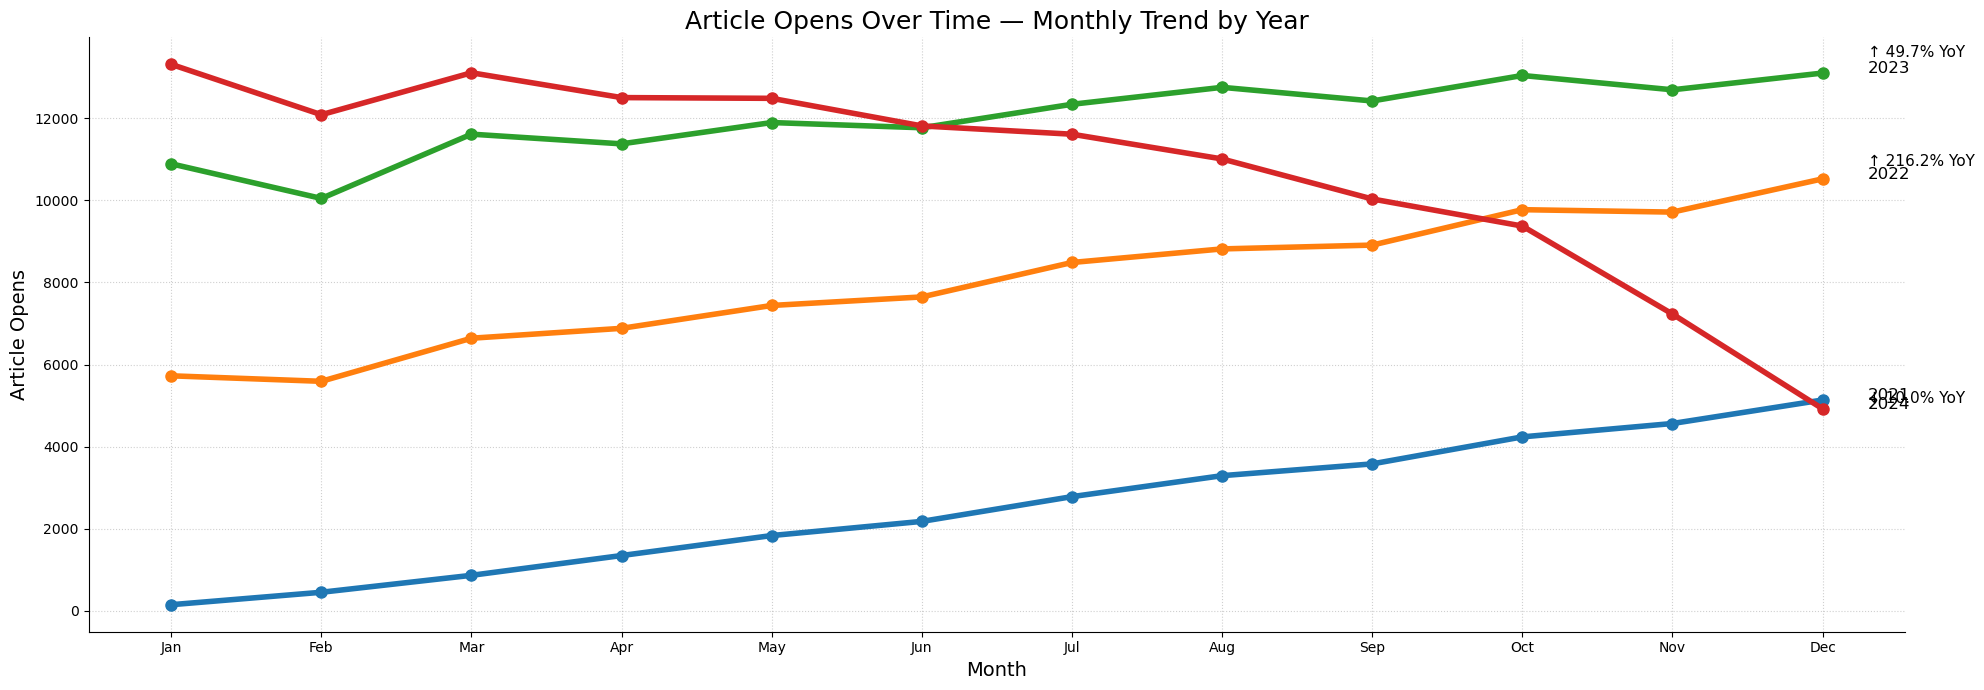

In [13]:


df["session_start_ts"] = pd.to_datetime(df["session_start_ts"])
df["year"] = df["session_start_ts"].dt.year
df["month"] = df["session_start_ts"].dt.month

monthly = (
    df.groupby(["year", "month"])
      .size()
      .reset_index(name="opens")
)

pivot = monthly.pivot(index="month", columns="year", values="opens").fillna(0)

year_totals = df.groupby("year").size().sort_index()
yoy_growth = (year_totals.pct_change() * 100).round(1)

# 🔥 Wider chart here
fig, ax = plt.subplots(figsize=(20, 7))   # wider layout

months = np.arange(1, 13)
month_labels = ["Jan","Feb","Mar","Apr","May","Jun",
                "Jul","Aug","Sep","Oct","Nov","Dec"]

for year in pivot.columns:
    y = pivot[year]
    ax.plot(months, y, linewidth=4, marker="o", markersize=8)

    ax.annotate(str(year),
                xy=(12, y.iloc[-1]),
                xytext=(12.3, y.iloc[-1]),
                fontsize=12)

for year in year_totals.index[1:]:
    growth = yoy_growth.loc[year]
    arrow = "↑" if growth > 0 else "↓"
    dec_val = pivot.loc[12, year]

    ax.annotate(f"{arrow} {abs(growth)}% YoY",
                xy=(12, dec_val),
                xytext=(12.3, dec_val * 1.03),
                fontsize=11)

ax.set_title("Article Opens Over Time — Monthly Trend by Year", fontsize=18)
ax.set_xlabel("Month", fontsize=14)
ax.set_ylabel("Article Opens", fontsize=14)

ax.set_xticks(months)
ax.set_xticklabels(month_labels)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(True, linestyle=":", alpha=0.6)

plt.tight_layout()
plt.show()


# Geolocation Analysis: Comparing States for reaching the bottom of a given article

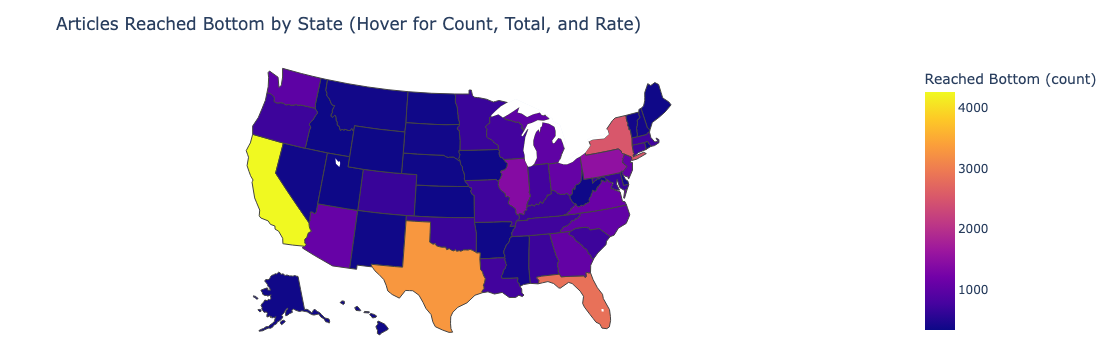

In [17]:
df["reached_bottom"] = pd.to_numeric(df["reached_bottom"], errors="coerce").fillna(0).astype(int)
df["user_state"] = df["user_state"].astype(str).str.strip()

state_agg = (
    df.groupby("user_state")
      .agg(reached_bottom_count=("reached_bottom", "sum"),
           total_opens=("reached_bottom", "size"))
      .reset_index()
)

state_agg["reached_bottom_rate"] = (
    state_agg["reached_bottom_count"] / state_agg["total_opens"] * 100
).round(2)

fig = px.choropleth(
    state_agg,
    locations="user_state",
    locationmode="USA-states",
    scope="usa",
    color="reached_bottom_count",
    hover_name="user_state",
    hover_data={
        "reached_bottom_count": ":,",
        "total_opens": ":,",
        "reached_bottom_rate": True,
        "user_state": False
    },
    labels={
        "reached_bottom_count": "Reached Bottom (count)",
        "total_opens": "Total Opens",
        "reached_bottom_rate": "Reached Bottom (%)"
    },
    title="Articles Reached Bottom by State (Hover for Count, Total, and Rate)"
)

fig.update_layout(margin=dict(l=20, r=20, t=60, b=20))



# States reaching the bottom of article: Top 5  vs. Bottom 5 States

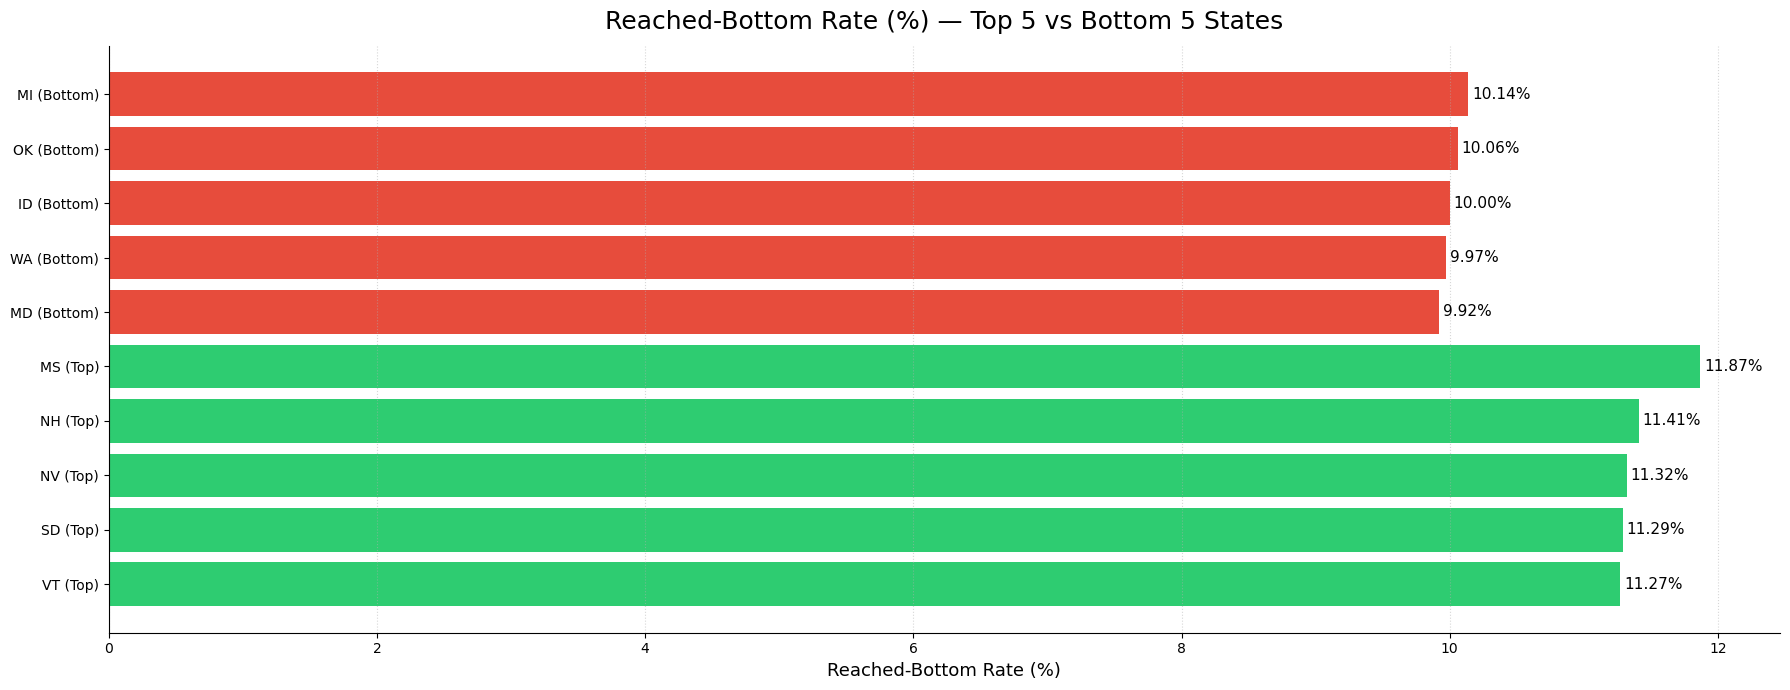

In [18]:

df["reached_bottom"] = pd.to_numeric(df["reached_bottom"], errors="coerce").fillna(0).astype(int)
df["user_state"] = df["user_state"].astype(str).str.strip()

# Aggregate by state
state_agg = (
    df.groupby("user_state")
      .agg(reached_bottom_count=("reached_bottom", "sum"),
           total_opens=("reached_bottom", "size"))
      .reset_index()
)
state_agg["reached_bottom_rate"] = (state_agg["reached_bottom_count"] / state_agg["total_opens"] * 100)

# Top & bottom 5 by rate
top5 = state_agg.sort_values("reached_bottom_rate", ascending=False).head(5).copy()
bottom5 = state_agg.sort_values("reached_bottom_rate", ascending=True).head(5).copy()

top5["group"] = "Top 5"
bottom5["group"] = "Bottom 5"
top5["state_label"] = top5["user_state"] + " (Top)"
bottom5["state_label"] = bottom5["user_state"] + " (Bottom)"

plot_df = pd.concat([top5, bottom5], ignore_index=True)
plot_df["reached_bottom_rate"] = plot_df["reached_bottom_rate"].round(2)

# Order: bottom group first (so top group ends up visually “on top” after inversion)
plot_df["order_key"] = plot_df["group"].map({"Top 5": 0, "Bottom 5": 1})
plot_df = plot_df.sort_values(["order_key", "reached_bottom_rate"], ascending=[True, True])

# Plot
fig, ax = plt.subplots(figsize=(18, 7))  # wide

colors = ["#2ecc71"] * 5 + ["#e74c3c"] * 5  # green top, red bottom
bars = ax.barh(plot_df["state_label"], plot_df["reached_bottom_rate"], color=colors)

ax.set_title("Reached-Bottom Rate (%) — Top 5 vs Bottom 5 States", fontsize=18, pad=12)
ax.set_xlabel("Reached-Bottom Rate (%)", fontsize=13)
ax.set_ylabel("")

# Data labels
for bar in bars:
    w = bar.get_width()
    y = bar.get_y() + bar.get_height() / 2
    ax.text(w + 0.03, y, f"{w:.2f}%", va="center", fontsize=11)

ax.grid(axis="x", linestyle=":", alpha=0.5)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()


# State by State popularity by Article Domain 

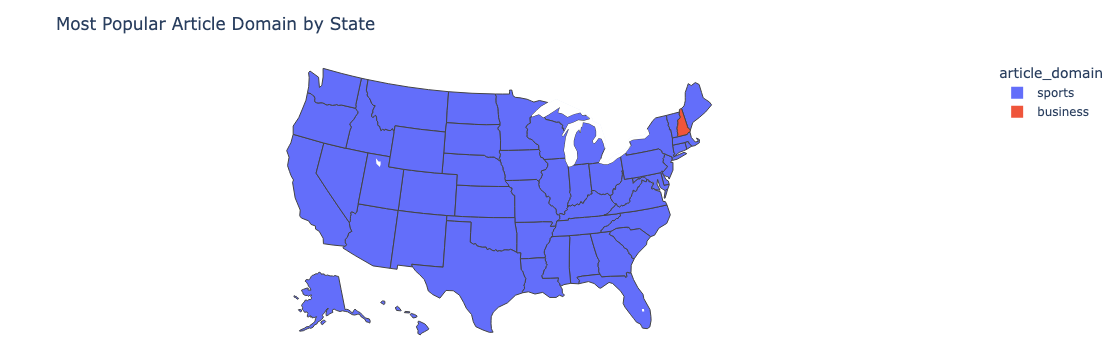

In [20]:


df["user_state"] = df["user_state"].astype(str).str.strip()
df["article_domain"] = df["article_domain"].astype(str)

# Count articles by state and domain
state_domain = (
    df.groupby(["user_state", "article_domain"])
      .size()
      .reset_index(name="article_count")
)

# Get most popular domain per state
idx = state_domain.groupby("user_state")["article_count"].idxmax()
top_domain_by_state = state_domain.loc[idx].reset_index(drop=True)

# Interactive choropleth
fig = px.choropleth(
    top_domain_by_state,
    locations="user_state",
    locationmode="USA-states",
    scope="usa",
    color="article_domain",
    hover_name="user_state",
    hover_data={
        "article_domain": True,
        "article_count": True
    },
    title="Most Popular Article Domain by State"
)

fig.update_layout(margin=dict(l=20, r=20, t=60, b=20))



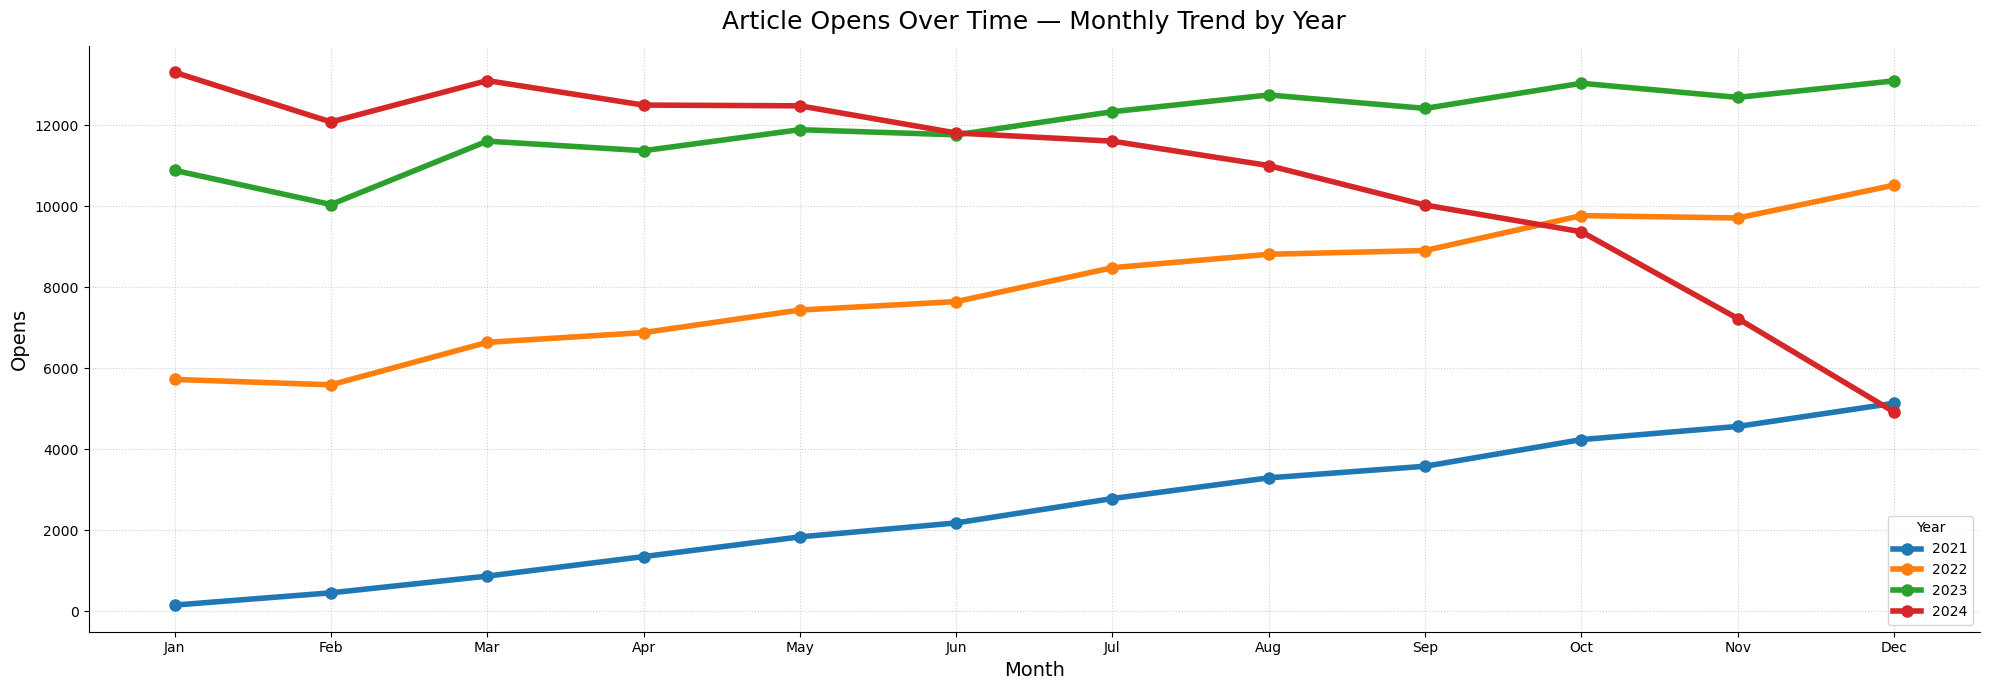

In [24]:
# Parse timestamps
df["session_start_ts"] = pd.to_datetime(df["session_start_ts"], errors="coerce")
df = df.dropna(subset=["session_start_ts"])

# Ensure binary/int columns are numeric
binary_cols = ["reached_bottom", "breaking_news", "is_subscriber", "is_first_time_visit",
               "dim_screen", "increased_font", "clicked_suggested_link",
               "back_to_homepage", "watched_short_video"]
for c in binary_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0).astype(int)

# Add time features
df["year"] = df["session_start_ts"].dt.year
df["month"] = df["session_start_ts"].dt.month
df["week_start"] = df["session_start_ts"].dt.to_period("W").apply(lambda r: r.start_time)

# Helper: completion rate
def rate(series):
    return float(series.mean() * 100)

# -----------------------
# 1) Monthly opens trend (line per year)
# -----------------------
monthly = (df.groupby(["year", "month"]).size().reset_index(name="opens"))
pivot = monthly.pivot(index="month", columns="year", values="opens").fillna(0).sort_index()

fig, ax = plt.subplots(figsize=(20, 7))
months = np.arange(1, 13)
month_labels = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]

for y in pivot.columns:
    ax.plot(months, pivot[y].to_numpy(), linewidth=4, marker="o", markersize=8, label=str(y))

ax.set_title("Article Opens Over Time — Monthly Trend by Year", fontsize=18, pad=12)
ax.set_xlabel("Month", fontsize=14)
ax.set_ylabel("Opens", fontsize=14)
ax.set_xticks(months)
ax.set_xticklabels(month_labels)
ax.grid(True, linestyle=":", alpha=0.6)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.legend(title="Year")
plt.tight_layout()
plt.show()


# Weekly opens trend to see momentum at Granular level

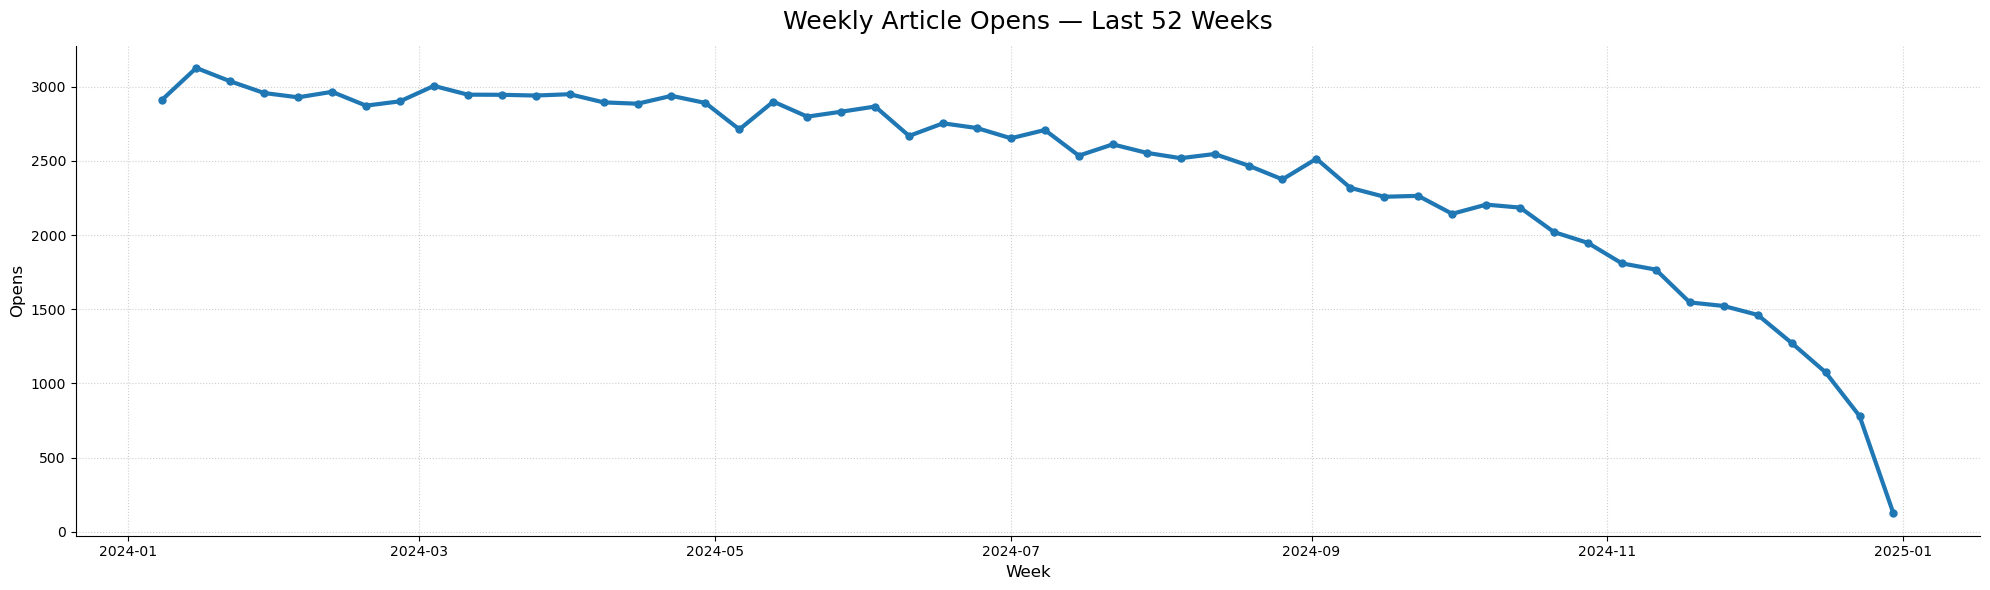

In [25]:
# 2) Weekly opens trend (recent 52 weeks) to see momentum
# -----------------------
weekly = df.groupby("week_start").size().reset_index(name="opens").sort_values("week_start")
weekly_last = weekly.tail(52)

fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(weekly_last["week_start"], weekly_last["opens"], linewidth=3, marker="o", markersize=5)
ax.set_title("Weekly Article Opens — Last 52 Weeks", fontsize=18, pad=12)
ax.set_xlabel("Week", fontsize=12)
ax.set_ylabel("Opens", fontsize=12)
ax.grid(True, linestyle=":", alpha=0.6)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.tight_layout()
plt.show()


# Traffic vs Completion Rate

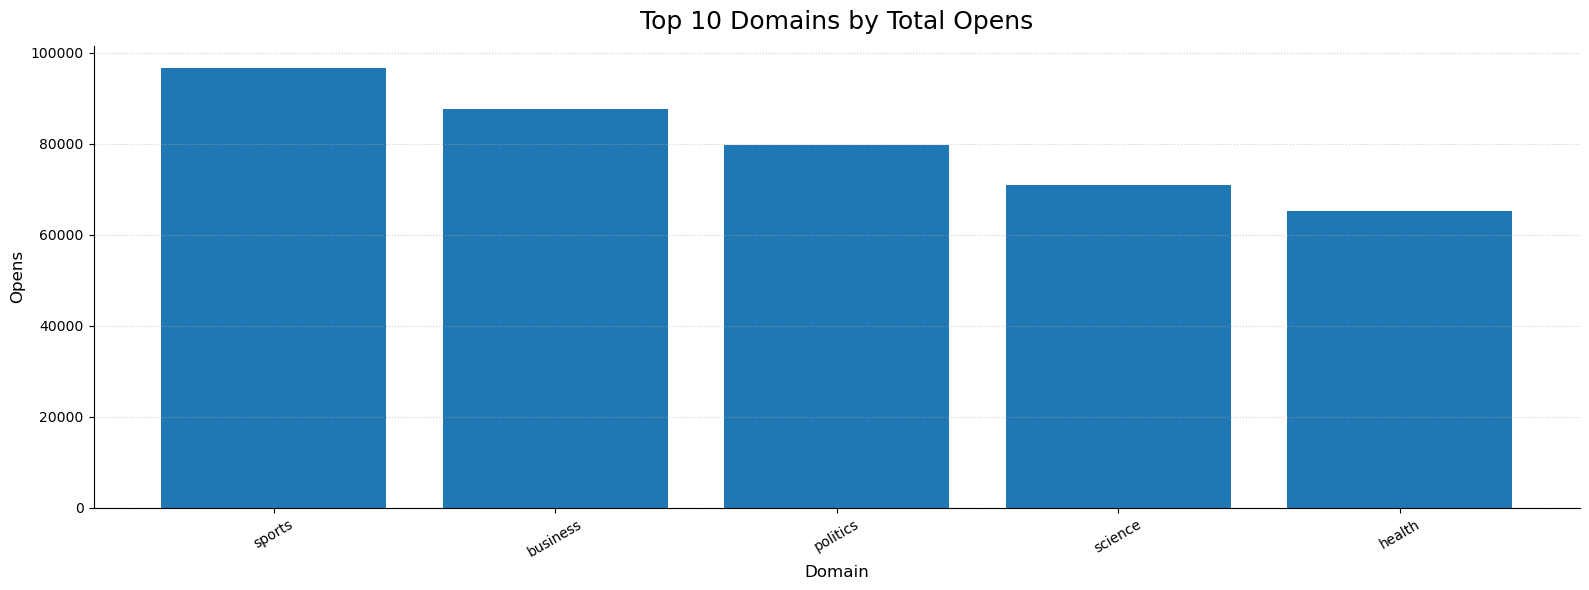

In [26]:
# -----------------------
# 3) Domain: traffic vs completion rate
# -----------------------
domain_agg = (df.groupby("article_domain")
                .agg(opens=("article_domain","size"),
                     reached_bottom_rate=("reached_bottom", rate))
                .reset_index()
                .sort_values("opens", ascending=False))

top_domains = domain_agg.head(10).copy()

# 3a) Opens by domain
fig, ax = plt.subplots(figsize=(16, 6))
ax.bar(top_domains["article_domain"], top_domains["opens"])
ax.set_title("Top 10 Domains by Total Opens", fontsize=18, pad=12)
ax.set_xlabel("Domain", fontsize=12)
ax.set_ylabel("Opens", fontsize=12)
ax.tick_params(axis="x", rotation=30)
ax.grid(True, axis="y", linestyle=":", alpha=0.6)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.tight_layout()
plt.show()


# Completion rate by Article Type

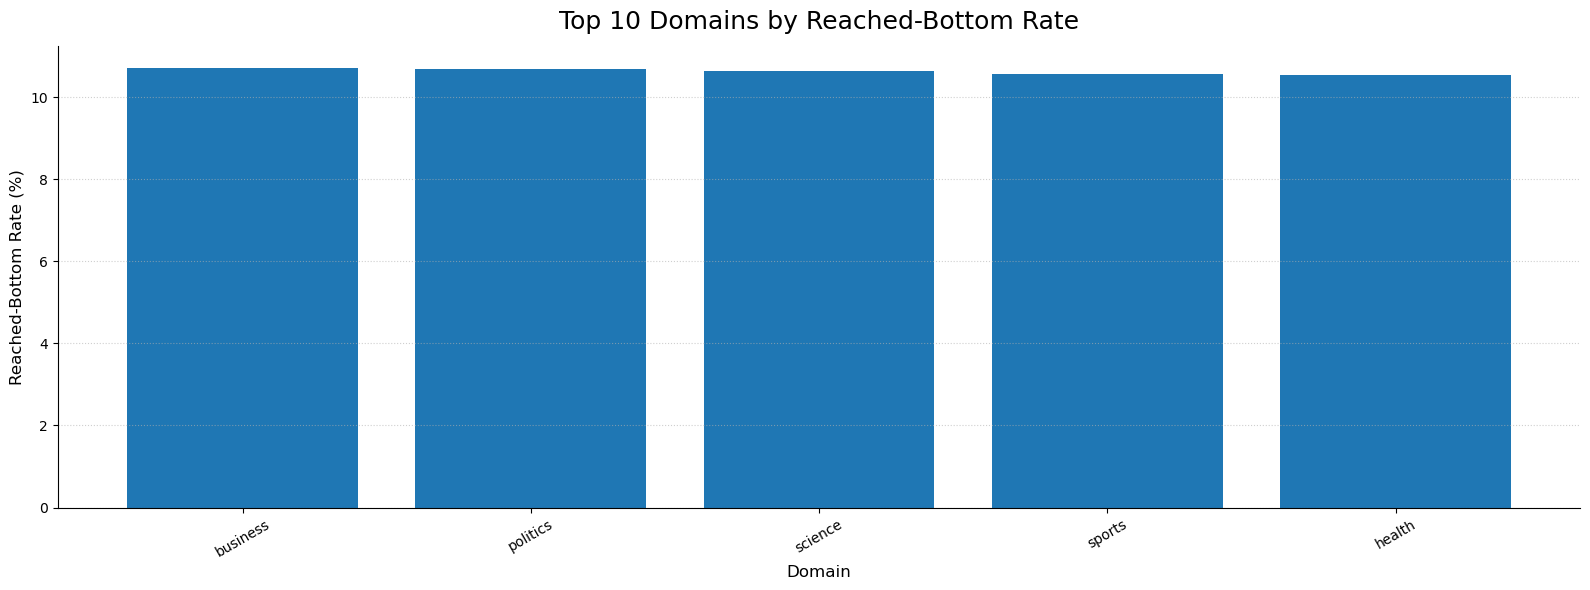

In [27]:
# 3b) Completion rate by domain
top_domains_rate = domain_agg.sort_values("reached_bottom_rate", ascending=False).head(10)

fig, ax = plt.subplots(figsize=(16, 6))
ax.bar(top_domains_rate["article_domain"], top_domains_rate["reached_bottom_rate"])
ax.set_title("Top 10 Domains by Reached-Bottom Rate", fontsize=18, pad=12)
ax.set_xlabel("Domain", fontsize=12)
ax.set_ylabel("Reached-Bottom Rate (%)", fontsize=12)
ax.tick_params(axis="x", rotation=30)
ax.grid(True, axis="y", linestyle=":", alpha=0.6)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.tight_layout()
plt.show()


# Breaking news: does it change completion?

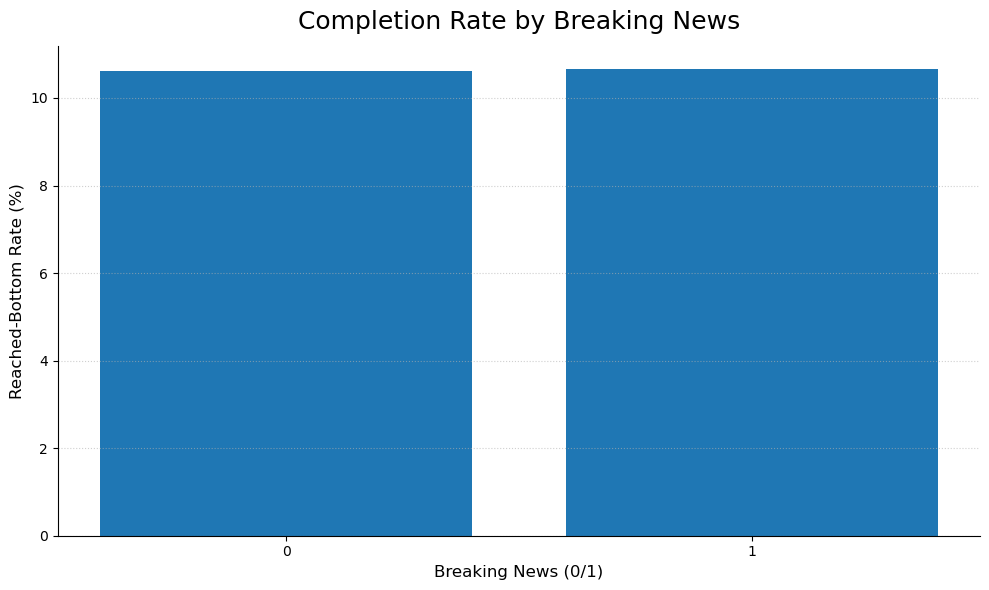

In [28]:

# -----------------------
bn = (df.groupby("breaking_news")
        .agg(opens=("breaking_news","size"),
             reached_bottom_rate=("reached_bottom", rate),
             avg_time_spent=("time_spent_sec","mean"))
        .reset_index())

# Bar: reached-bottom rate by breaking_news
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(bn["breaking_news"].astype(str), bn["reached_bottom_rate"])
ax.set_title("Completion Rate by Breaking News", fontsize=18, pad=12)
ax.set_xlabel("Breaking News (0/1)", fontsize=12)
ax.set_ylabel("Reached-Bottom Rate (%)", fontsize=12)
ax.grid(True, axis="y", linestyle=":", alpha=0.6)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.tight_layout()
plt.show()


# Comparing Mobile Platform for Article completions

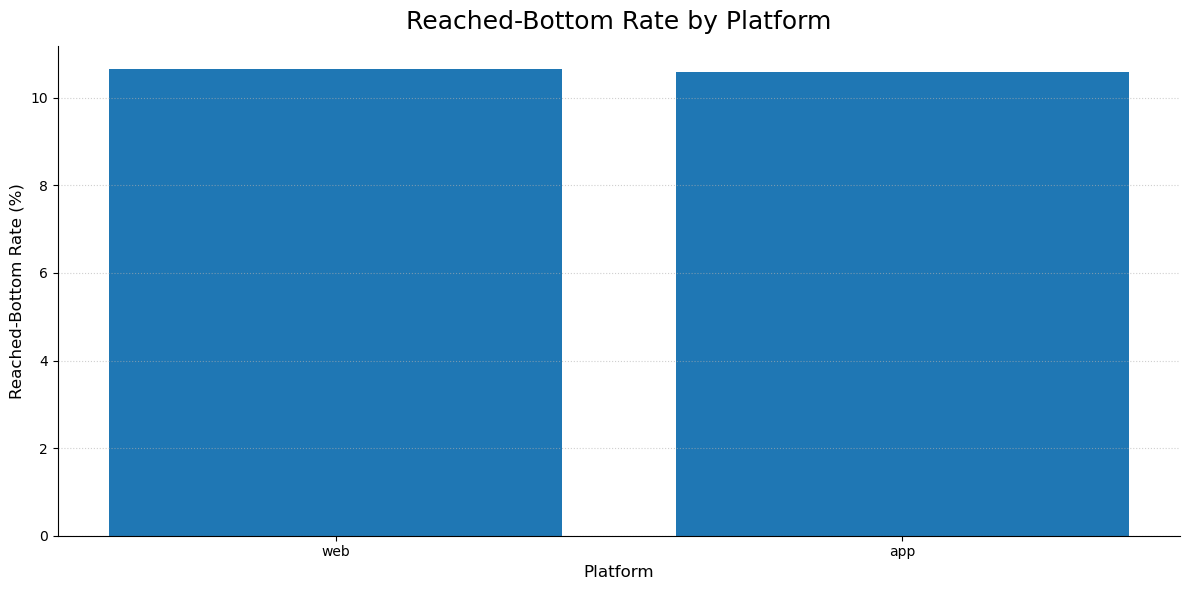

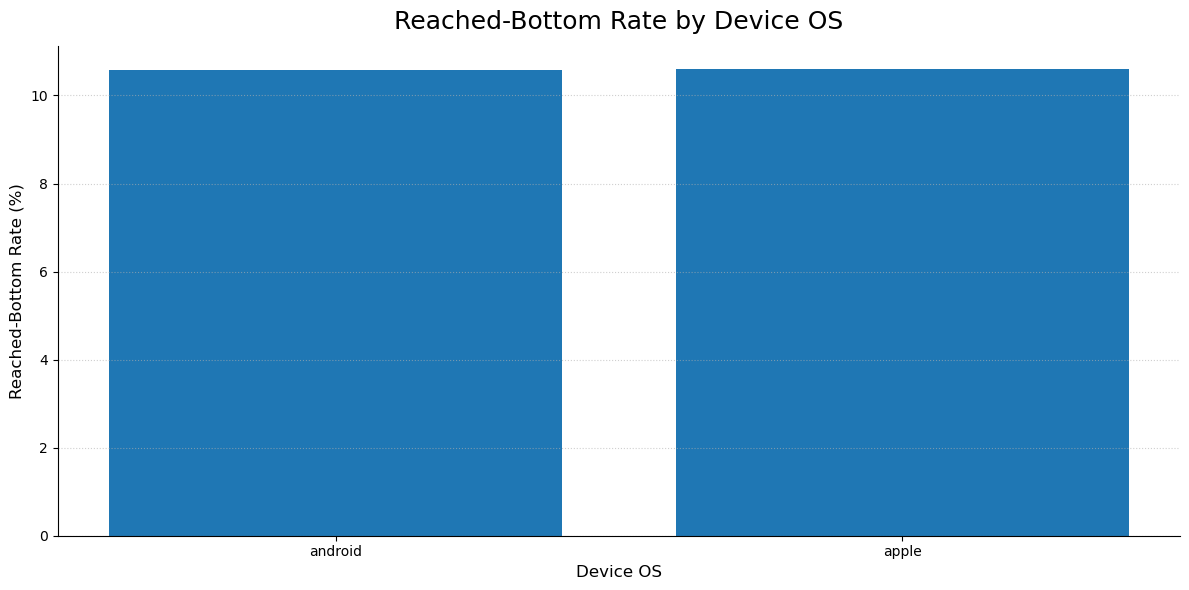

In [30]:
# 5) Platform & OS: where do people complete more?
# -----------------------
plat = (df.groupby("platform")
          .agg(opens=("platform","size"),
               reached_bottom_rate=("reached_bottom", rate))
          .reset_index()
          .sort_values("opens", ascending=False))

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(plat["platform"], plat["reached_bottom_rate"])
ax.set_title("Reached-Bottom Rate by Platform", fontsize=18, pad=12)
ax.set_xlabel("Platform", fontsize=12)
ax.set_ylabel("Reached-Bottom Rate (%)", fontsize=12)
ax.grid(True, axis="y", linestyle=":", alpha=0.6)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.tight_layout()
plt.show()
os_agg = (df.groupby("device_os")
            .agg(opens=("device_os","size"),
                 reached_bottom_rate=("reached_bottom", rate))
            .reset_index()
            .sort_values("opens", ascending=False))

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(os_agg["device_os"], os_agg["reached_bottom_rate"])
ax.set_title("Reached-Bottom Rate by Device OS", fontsize=18, pad=12)
ax.set_xlabel("Device OS", fontsize=12)
ax.set_ylabel("Reached-Bottom Rate (%)", fontsize=12)
ax.grid(True, axis="y", linestyle=":", alpha=0.6)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.tight_layout()
plt.show()


# Comparing Subscribers to first time visitors

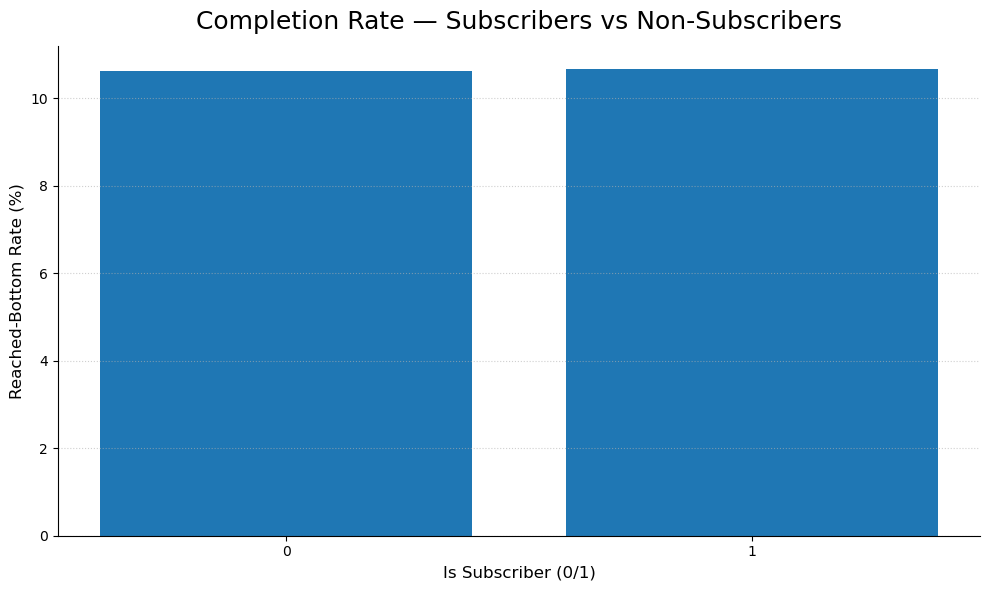

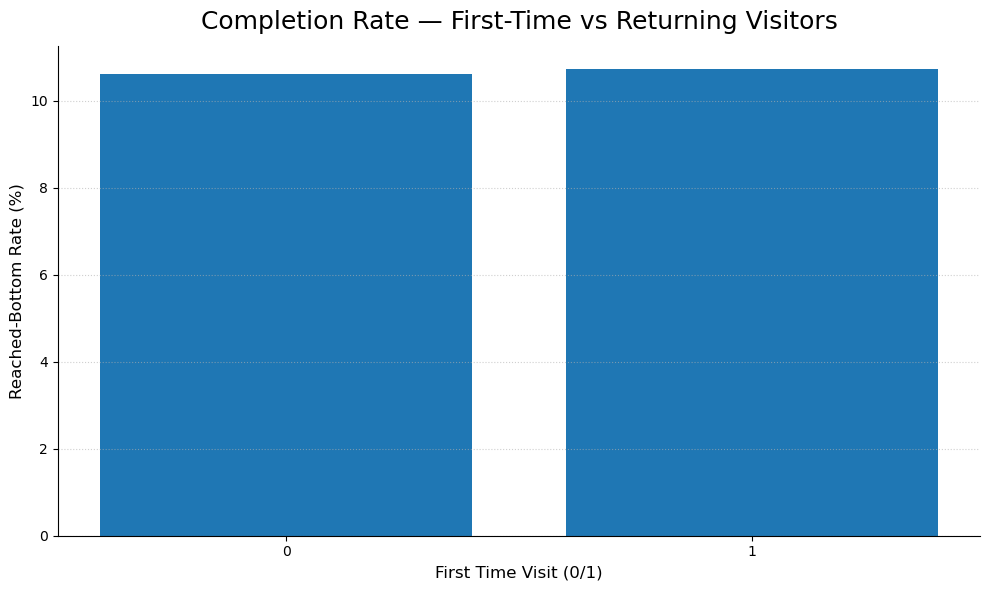

In [31]:
# -----------------------
# 6) Subscriber / first-time: who completes more?
# -----------------------
subs = (df.groupby("is_subscriber")
          .agg(opens=("is_subscriber","size"),
               reached_bottom_rate=("reached_bottom", rate))
          .reset_index())

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(subs["is_subscriber"].astype(str), subs["reached_bottom_rate"])
ax.set_title("Completion Rate — Subscribers vs Non-Subscribers", fontsize=18, pad=12)
ax.set_xlabel("Is Subscriber (0/1)", fontsize=12)
ax.set_ylabel("Reached-Bottom Rate (%)", fontsize=12)
ax.grid(True, axis="y", linestyle=":", alpha=0.6)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.tight_layout()
plt.show()

ft = (df.groupby("is_first_time_visit")
        .agg(opens=("is_first_time_visit","size"),
             reached_bottom_rate=("reached_bottom", rate))
        .reset_index())

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(ft["is_first_time_visit"].astype(str), ft["reached_bottom_rate"])
ax.set_title("Completion Rate — First-Time vs Returning Visitors", fontsize=18, pad=12)
ax.set_xlabel("First Time Visit (0/1)", fontsize=12)
ax.set_ylabel("Reached-Bottom Rate (%)", fontsize=12)
ax.grid(True, axis="y", linestyle=":", alpha=0.6)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.tight_layout()
plt.show()

# Engagement distribution: time spent by completion

/var/folders/v_/wt___8bn2w96qll7bdb9csb00000gn/T/ipykernel_48125/33053995.py:8: MatplotlibDeprecationWarning:

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.



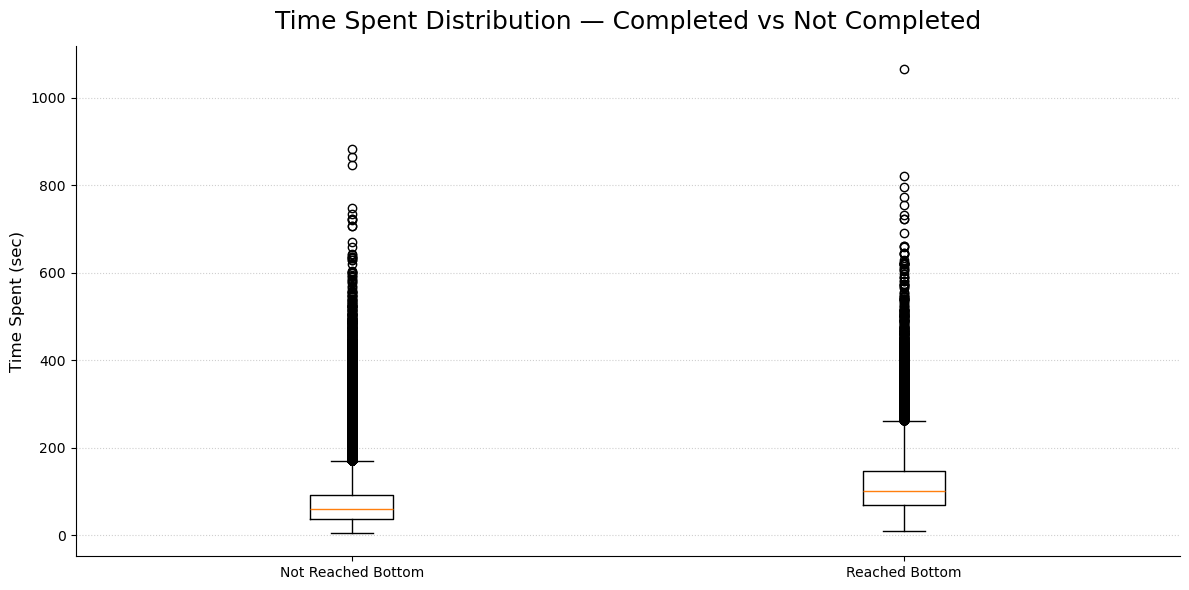

In [32]:
# -----------------------
# -----------------------
completed = df.loc[df["reached_bottom"] == 1, "time_spent_sec"].dropna()
not_completed = df.loc[df["reached_bottom"] == 0, "time_spent_sec"].dropna()

fig, ax = plt.subplots(figsize=(12, 6))
ax.boxplot([not_completed, completed], labels=["Not Reached Bottom", "Reached Bottom"])
ax.set_title("Time Spent Distribution — Completed vs Not Completed", fontsize=18, pad=12)
ax.set_ylabel("Time Spent (sec)", fontsize=12)
ax.grid(True, axis="y", linestyle=":", alpha=0.6)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.tight_layout()
plt.show()

# Numeric Engagement Signal

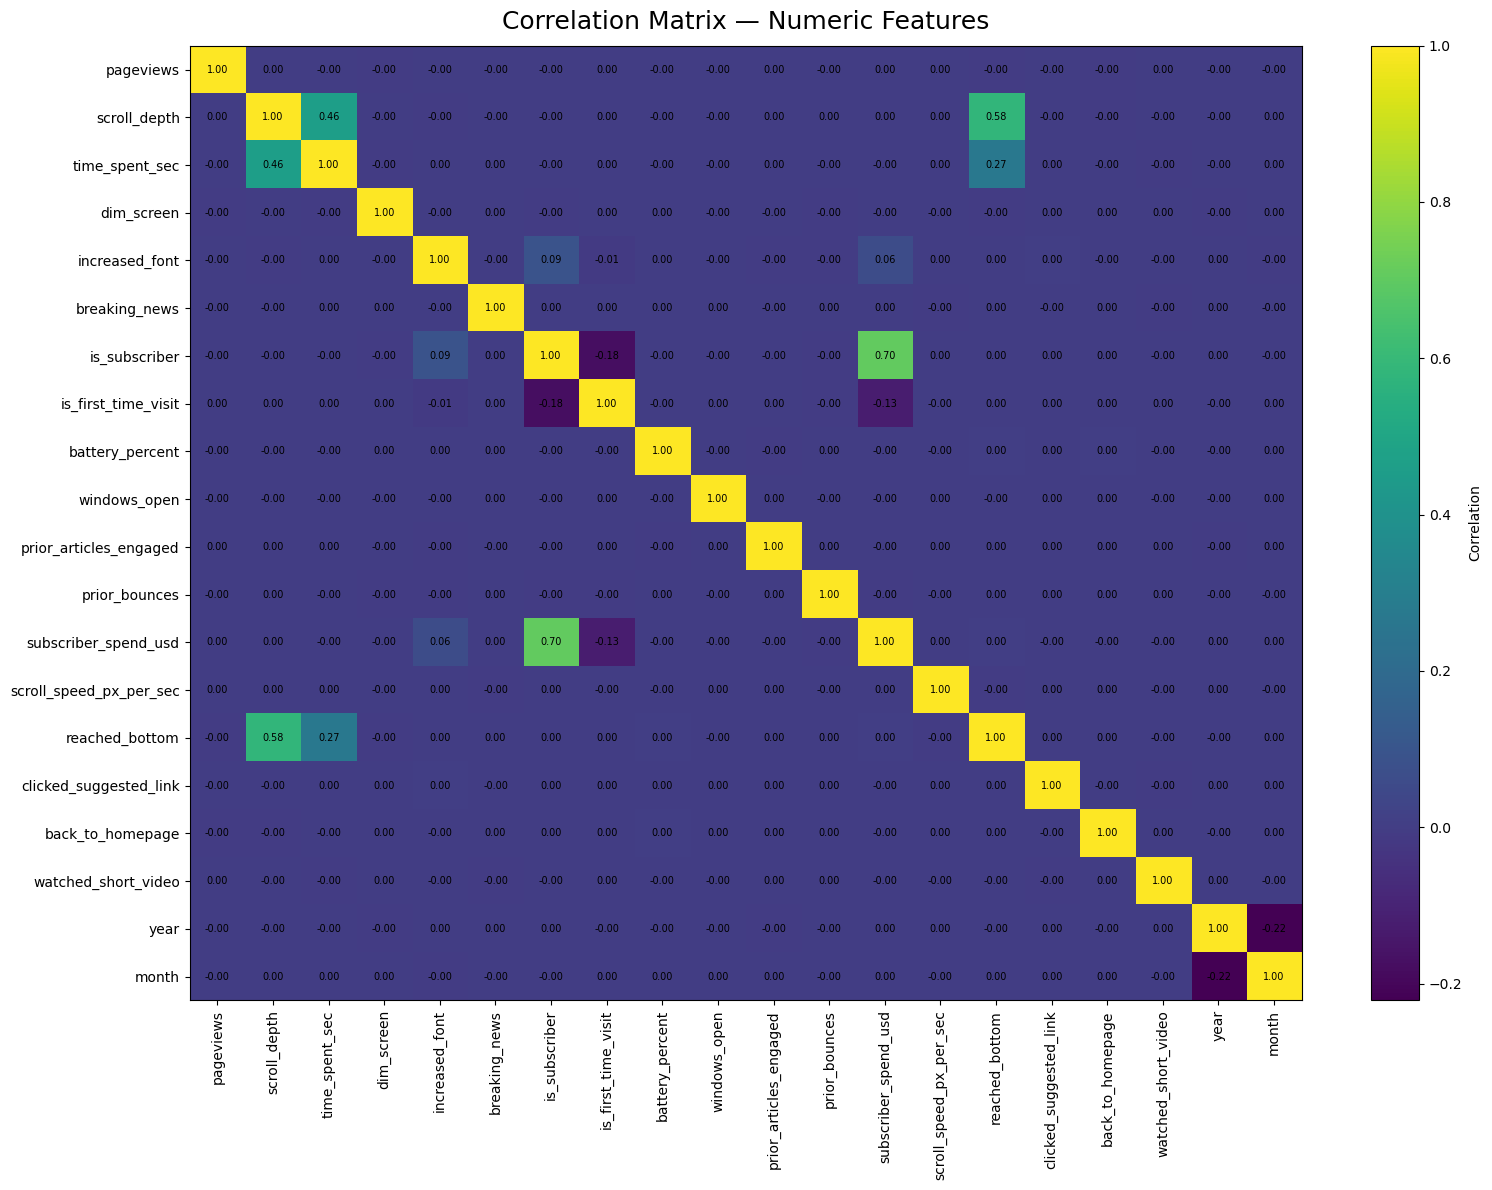

In [33]:
# -----------------------
# 8) Correlation heatmap (numeric engagement signals)
# -----------------------
numeric = df.select_dtypes(include=[np.number]).copy()

# Drop high-cardinality IDs if present
for col in ["user_id", "article_id"]:
    if col in numeric.columns:
        numeric.drop(columns=[col], inplace=True)

corr = numeric.corr()

fig, ax = plt.subplots(figsize=(16, 12))
im = ax.imshow(corr, aspect="auto")
cbar = fig.colorbar(im)
cbar.ax.set_ylabel("Correlation", rotation=90)

ax.set_xticks(np.arange(len(corr.columns)))
ax.set_yticks(np.arange(len(corr.columns)))
ax.set_xticklabels(corr.columns, rotation=90)
ax.set_yticklabels(corr.columns)
ax.set_title("Correlation Matrix — Numeric Features", fontsize=18, pad=12)

# Annotate (optional; comment out if too dense)
for i in range(len(corr.columns)):
    for j in range(len(corr.columns)):
        ax.text(j, i, f"{corr.iloc[i, j]:.2f}", ha="center", va="center", fontsize=7)

plt.tight_layout()
plt.show()


# Engagement Funnel: Opens → Clicks → Reached Bottom

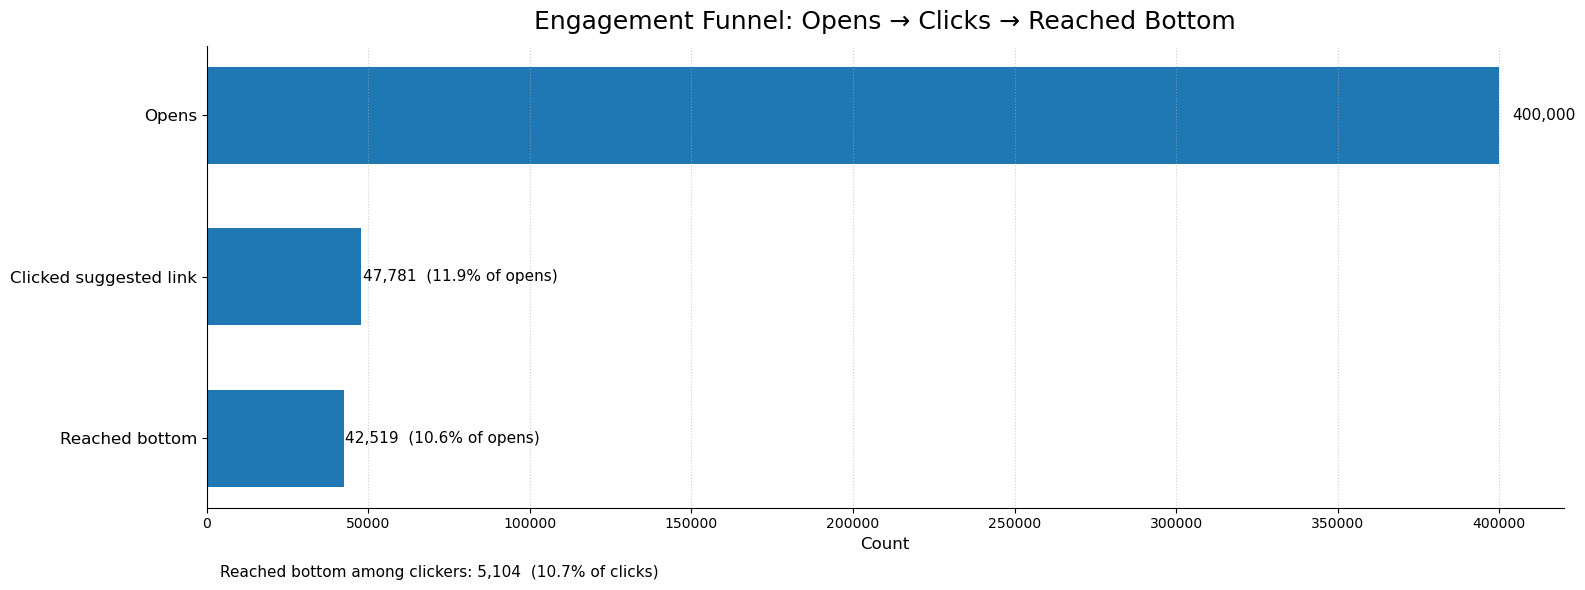

In [34]:

# Ensure numeric flags
df["clicked_suggested_link"] = pd.to_numeric(df["clicked_suggested_link"], errors="coerce").fillna(0).astype(int)
df["reached_bottom"] = pd.to_numeric(df["reached_bottom"], errors="coerce").fillna(0).astype(int)

opens = len(df)
clicks = int(df["clicked_suggested_link"].sum())
reached_bottom = int(df["reached_bottom"].sum())

# Optional "true funnel" metric: reached bottom among clickers
reached_bottom_among_clickers = int(df.loc[df["clicked_suggested_link"] == 1, "reached_bottom"].sum())

# Rates
click_rate = clicks / opens if opens else 0
reach_rate = reached_bottom / opens if opens else 0
reach_given_click = reached_bottom_among_clickers / clicks if clicks else 0

stages = ["Opens", "Clicked suggested link", "Reached bottom"]
values = [opens, clicks, reached_bottom]

# Funnel-style horizontal bars
fig, ax = plt.subplots(figsize=(16, 6))
ypos = np.arange(len(stages))

bars = ax.barh(ypos, values, height=0.6)
ax.invert_yaxis()

ax.set_yticks(ypos)
ax.set_yticklabels(stages, fontsize=12)
ax.set_xlabel("Count", fontsize=12)
ax.set_title("Engagement Funnel: Opens → Clicks → Reached Bottom", fontsize=18, pad=12)

# Labels on bars
annotations = [
    f"{opens:,}",
    f"{clicks:,}  ({click_rate*100:.1f}% of opens)",
    f"{reached_bottom:,}  ({reach_rate*100:.1f}% of opens)",
]

for bar, label in zip(bars, annotations):
    w = bar.get_width()
    y = bar.get_y() + bar.get_height() / 2
    ax.text(w * 1.01 if w > 0 else 0.01, y, label, va="center", fontsize=11)

# Extra note
note = f"Reached bottom among clickers: {reached_bottom_among_clickers:,}  ({reach_given_click*100:.1f}% of clicks)"
ax.text(0.01, -0.15, note, transform=ax.transAxes, fontsize=11)

ax.grid(True, axis="x", linestyle=":", alpha=0.6)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()

/var/folders/v_/wt___8bn2w96qll7bdb9csb00000gn/T/ipykernel_49169/2630072634.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("engaged_bucket")


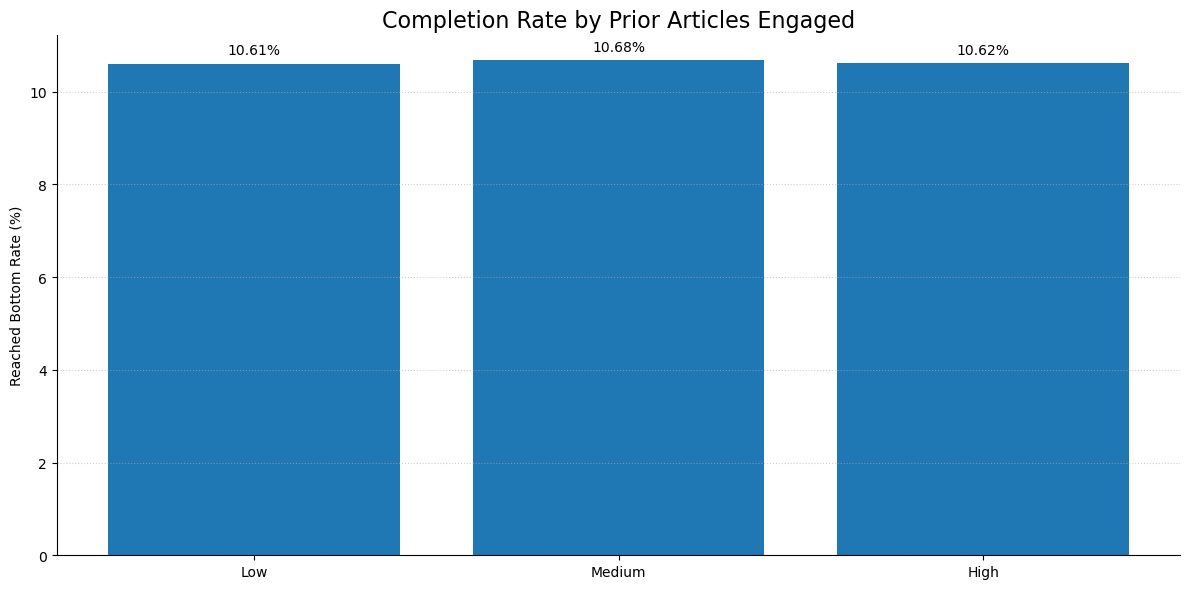

/var/folders/v_/wt___8bn2w96qll7bdb9csb00000gn/T/ipykernel_49169/2630072634.py:47: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("bounce_bucket")


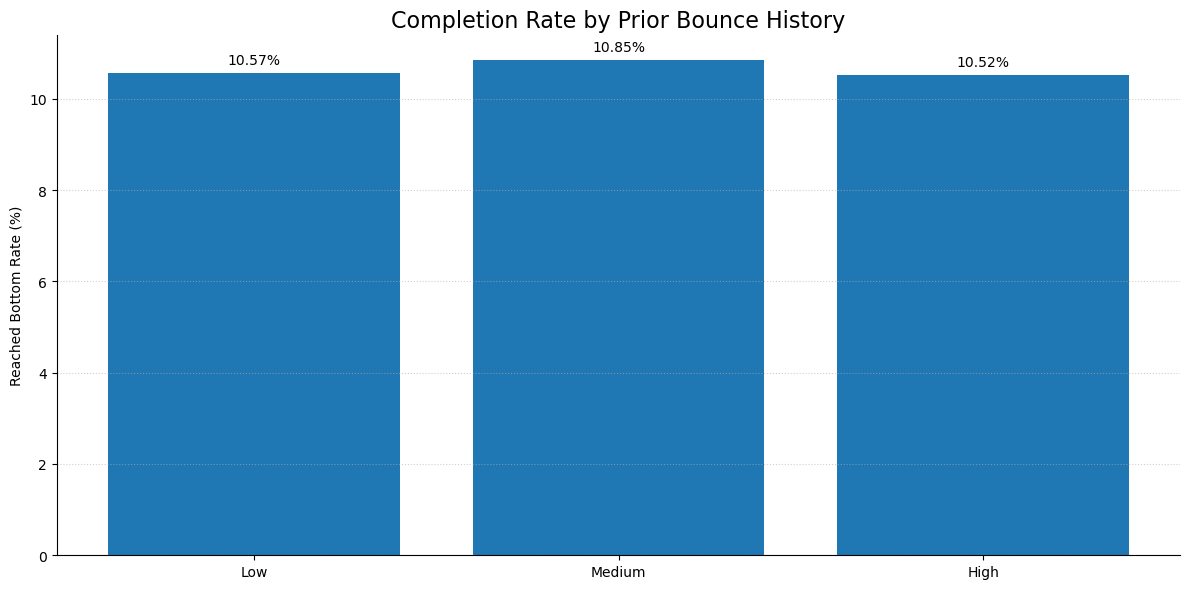

Prior Articles Engaged Impact
  engaged_bucket  completion_rate  avg_time_spent
0            Low        10.606195       76.158506
1         Medium        10.682017       75.988930
2           High        10.618335       76.292718

Prior Bounce Impact
  bounce_bucket  completion_rate  avg_time_spent
0           Low        10.570316       76.260362
1        Medium        10.849611       75.956700
2          High        10.521303       76.177682


In [6]:
# Ensure numeric
df["prior_articles_engaged"] = pd.to_numeric(df["prior_articles_engaged"], errors="coerce").fillna(0)
df["prior_bounces"] = pd.to_numeric(df["prior_bounces"], errors="coerce").fillna(0)
df["reached_bottom"] = pd.to_numeric(df["reached_bottom"], errors="coerce").fillna(0)
df["time_spent_sec"] = pd.to_numeric(df["time_spent_sec"], errors="coerce").fillna(0)

# ---------------------------------------
# 1️⃣ Prior Articles Engaged → Future Engagement
# ---------------------------------------

# Create buckets
df["engaged_bucket"] = pd.qcut(df["prior_articles_engaged"], 3, labels=["Low", "Medium", "High"])

engaged_analysis = (
    df.groupby("engaged_bucket")
      .agg(
          completion_rate=("reached_bottom", "mean"),
          avg_time_spent=("time_spent_sec", "mean")
      )
      .reset_index()
)

engaged_analysis["completion_rate"] *= 100

# Completion Rate Chart
fig, ax = plt.subplots(figsize=(12,6))
ax.bar(engaged_analysis["engaged_bucket"], engaged_analysis["completion_rate"])
ax.set_title("Completion Rate by Prior Articles Engaged", fontsize=16)
ax.set_ylabel("Reached Bottom Rate (%)")
ax.grid(axis="y", linestyle=":", alpha=0.6)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

for i, v in enumerate(engaged_analysis["completion_rate"]):
    ax.text(i, v + 0.2, f"{v:.2f}%", ha="center")

plt.tight_layout()
plt.show()

# ---------------------------------------
# 2️⃣ Prior Bounces → Future Engagement
# ---------------------------------------

df["bounce_bucket"] = pd.qcut(df["prior_bounces"], 3, labels=["Low", "Medium", "High"])

bounce_analysis = (
    df.groupby("bounce_bucket")
      .agg(
          completion_rate=("reached_bottom", "mean"),
          avg_time_spent=("time_spent_sec", "mean")
      )
      .reset_index()
)

bounce_analysis["completion_rate"] *= 100

# Completion Rate by Bounce History
fig, ax = plt.subplots(figsize=(12,6))
ax.bar(bounce_analysis["bounce_bucket"], bounce_analysis["completion_rate"])
ax.set_title("Completion Rate by Prior Bounce History", fontsize=16)
ax.set_ylabel("Reached Bottom Rate (%)")
ax.grid(axis="y", linestyle=":", alpha=0.6)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

for i, v in enumerate(bounce_analysis["completion_rate"]):
    ax.text(i, v + 0.2, f"{v:.2f}%", ha="center")

plt.tight_layout()
plt.show()

# ---------------------------------------
# Optional: Print Summary Tables
# ---------------------------------------
print("Prior Articles Engaged Impact")
print(engaged_analysis)

print("\nPrior Bounce Impact")
print(bounce_analysis)

# What words/phrases are most common in titles vs bodies?

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
import re

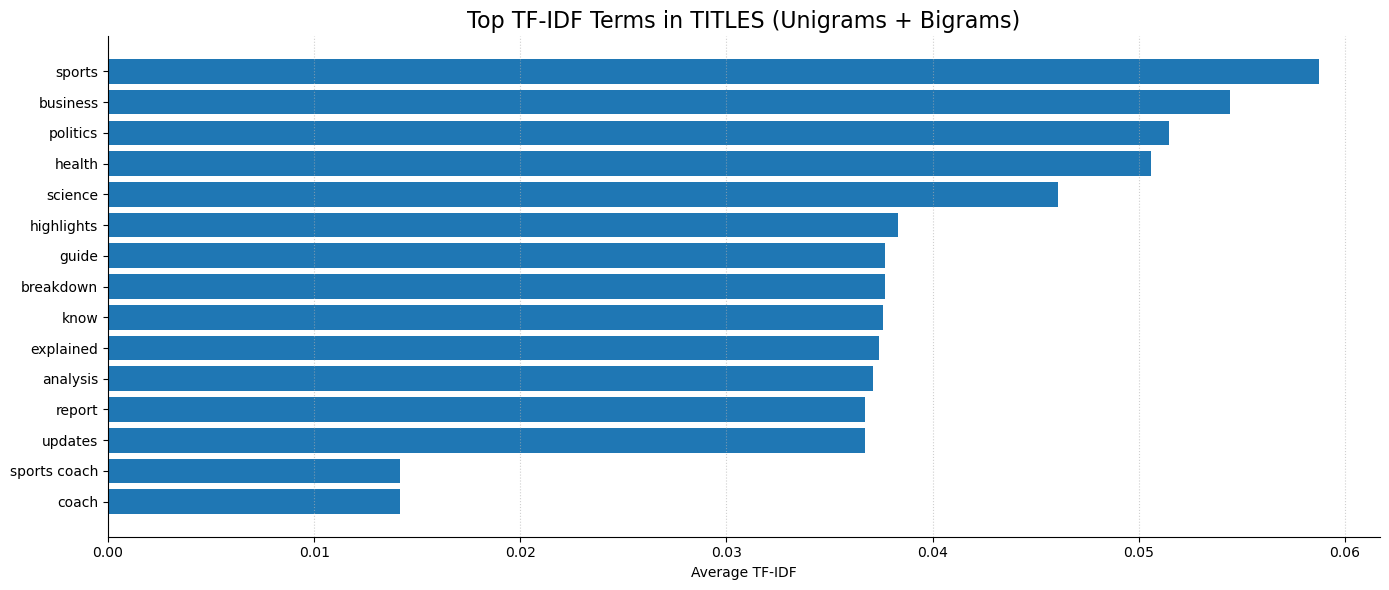

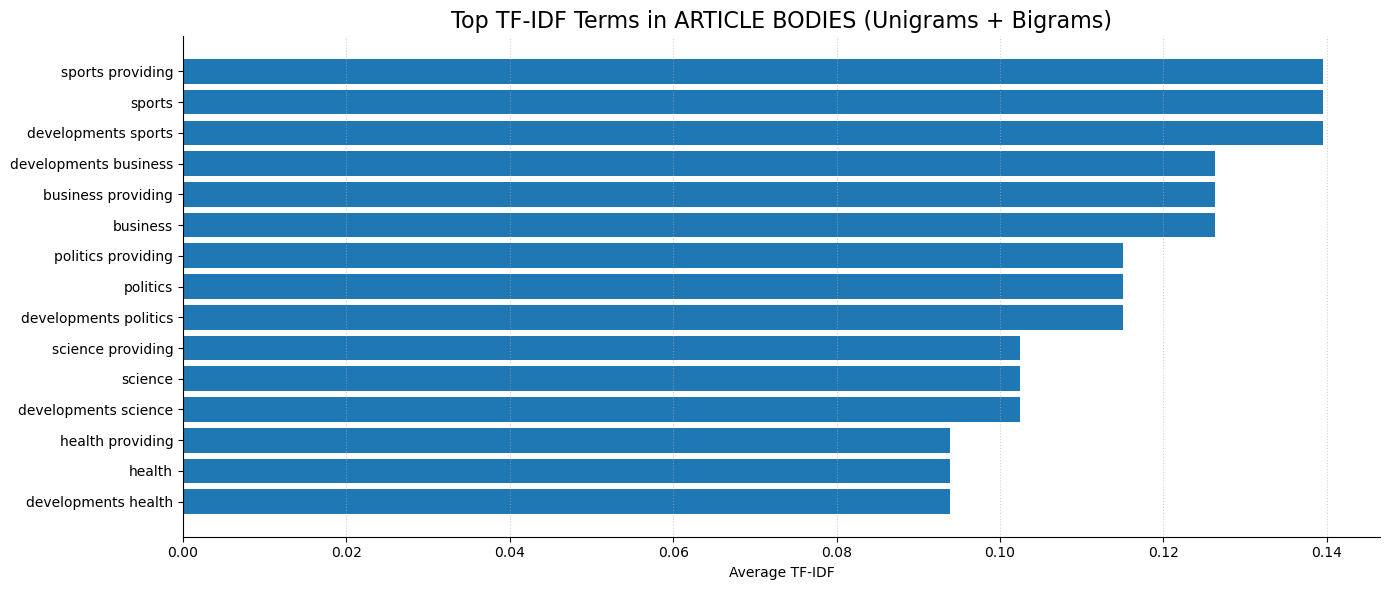

In [10]:
# 1) What words/phrases are most common in titles vs bodies?

def clean_text(s):
    s = str(s).lower()
    s = re.sub(r"http\S+|www\S+", " ", s)
    s = re.sub(r"[^a-z\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

df["title_clean"] = df["article_title"].fillna("").map(clean_text)
df["body_clean"]  = df["article_body"].fillna("").map(clean_text)

def top_terms(text_series, ngram_range=(1,2), top_k=15):
    vec = TfidfVectorizer(stop_words="english", ngram_range=ngram_range, min_df=10, max_df=0.7)
    X = vec.fit_transform(text_series)
    scores = np.asarray(X.mean(axis=0)).ravel()
    terms = np.array(vec.get_feature_names_out())
    top_idx = np.argsort(scores)[-top_k:][::-1]
    return terms[top_idx], scores[top_idx]

title_terms, title_scores = top_terms(df["title_clean"], ngram_range=(1,2), top_k=15)
body_terms, body_scores   = top_terms(df["body_clean"],  ngram_range=(1,2), top_k=15)

# Plot titles
fig, ax = plt.subplots(figsize=(14, 6))
ax.barh(title_terms[::-1], title_scores[::-1])
ax.set_title("Top TF-IDF Terms in TITLES (Unigrams + Bigrams)", fontsize=16)
ax.set_xlabel("Average TF-IDF")
ax.grid(True, axis="x", linestyle=":", alpha=0.6)
ax.spines["top"].set_visible(False); ax.spines["right"].set_visible(False)
plt.tight_layout(); plt.show()

# Plot bodies
fig, ax = plt.subplots(figsize=(14, 6))
ax.barh(body_terms[::-1], body_scores[::-1])
ax.set_title("Top TF-IDF Terms in ARTICLE BODIES (Unigrams + Bigrams)", fontsize=16)
ax.set_xlabel("Average TF-IDF")
ax.grid(True, axis="x", linestyle=":", alpha=0.6)
ax.spines["top"].set_visible(False); ax.spines["right"].set_visible(False)
plt.tight_layout(); plt.show()

# Which phrases are associated with reaching the bottom

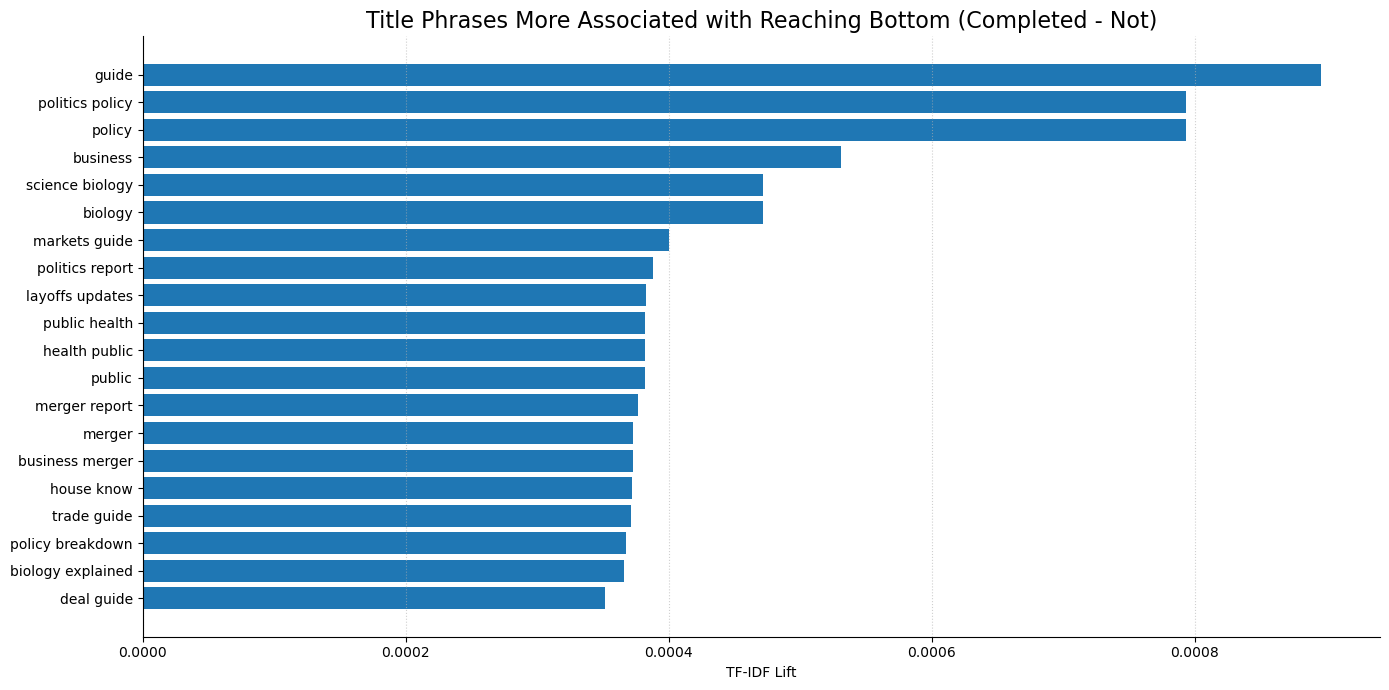

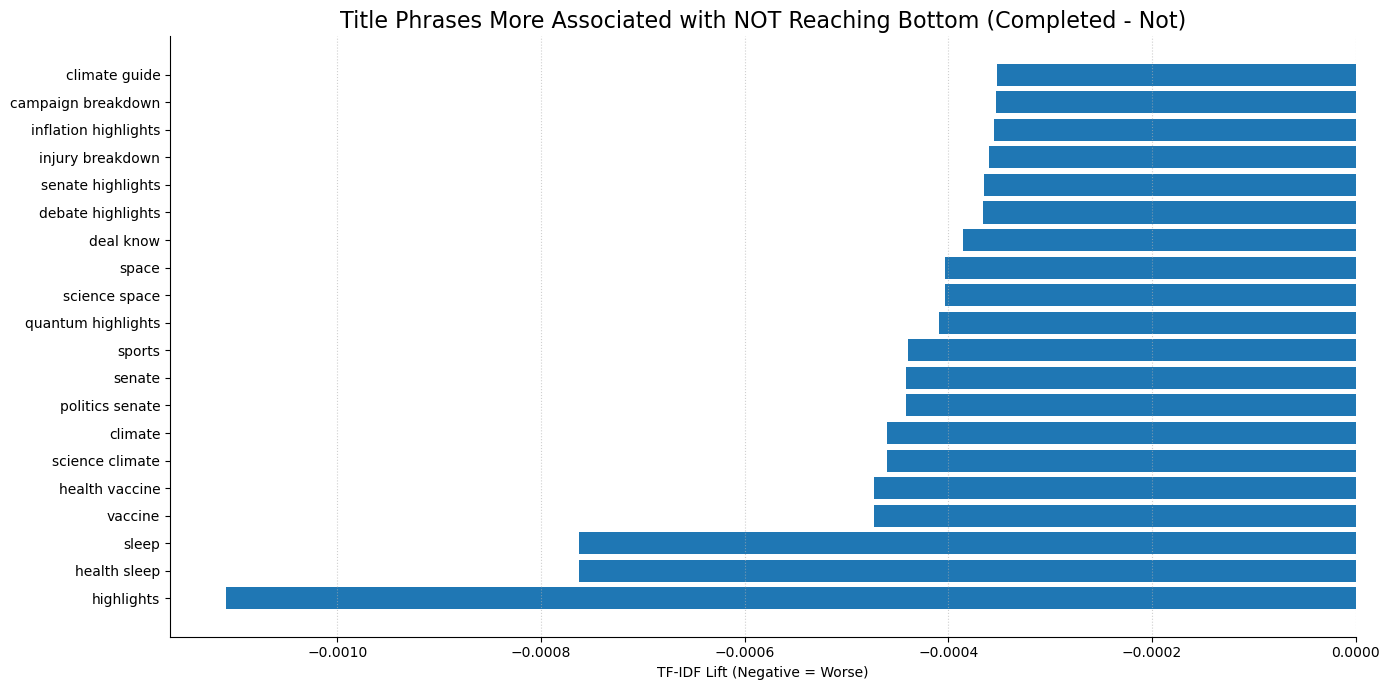

In [12]:
# ?

df["reached_bottom"] = pd.to_numeric(df["reached_bottom"], errors="coerce").fillna(0).astype(int)

completed = df[df["reached_bottom"] == 1]["title_clean"]
not_completed = df[df["reached_bottom"] == 0]["title_clean"]

vec = TfidfVectorizer(stop_words="english", ngram_range=(1,2), min_df=10, max_df=0.7)
X_all = vec.fit_transform(df["title_clean"])
terms = np.array(vec.get_feature_names_out())

X_c = vec.transform(completed)
X_n = vec.transform(not_completed)

score_c = np.asarray(X_c.mean(axis=0)).ravel()
score_n = np.asarray(X_n.mean(axis=0)).ravel()

lift = score_c - score_n  # positive => more associated with completion
top_k = 20
top_idx = np.argsort(lift)[-top_k:][::-1]
bot_idx = np.argsort(lift)[:top_k]

# Plot phrases more associated with completion
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(14, 7))
ax.barh(terms[top_idx][::-1], lift[top_idx][::-1])
ax.set_title("Title Phrases More Associated with Reaching Bottom (Completed - Not)", fontsize=16)
ax.set_xlabel("TF-IDF Lift")
ax.grid(True, axis="x", linestyle=":", alpha=0.6)
ax.spines["top"].set_visible(False); ax.spines["right"].set_visible(False)
plt.tight_layout(); plt.show()

# Plot phrases more associated with non-completion
fig, ax = plt.subplots(figsize=(14, 7))
ax.barh(terms[bot_idx], lift[bot_idx])
ax.set_title("Title Phrases More Associated with NOT Reaching Bottom (Completed - Not)", fontsize=16)
ax.set_xlabel("TF-IDF Lift (Negative = Worse)")
ax.grid(True, axis="x", linestyle=":", alpha=0.6)
ax.spines["top"].set_visible(False); ax.spines["right"].set_visible(False)
plt.tight_layout(); plt.show()

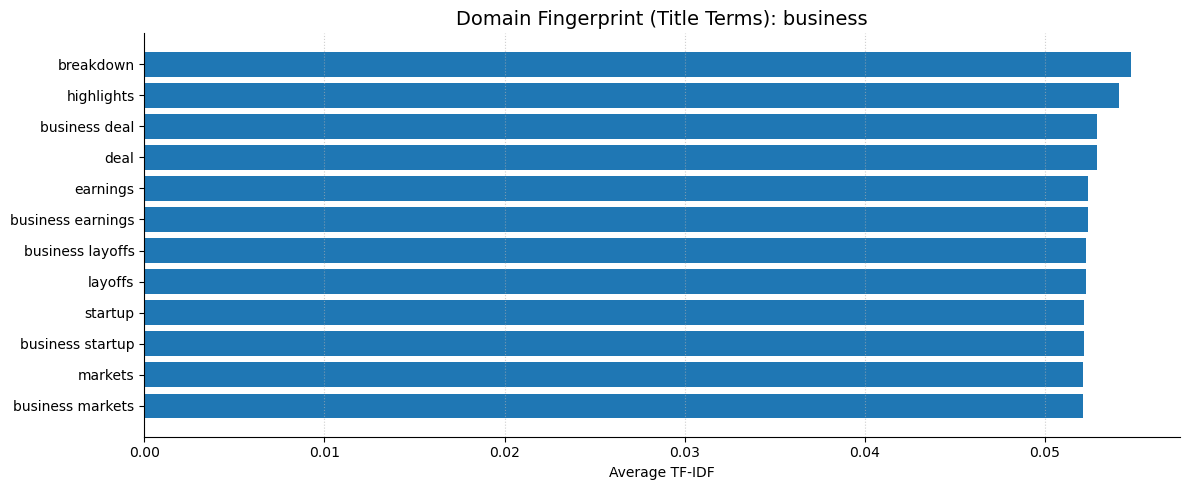

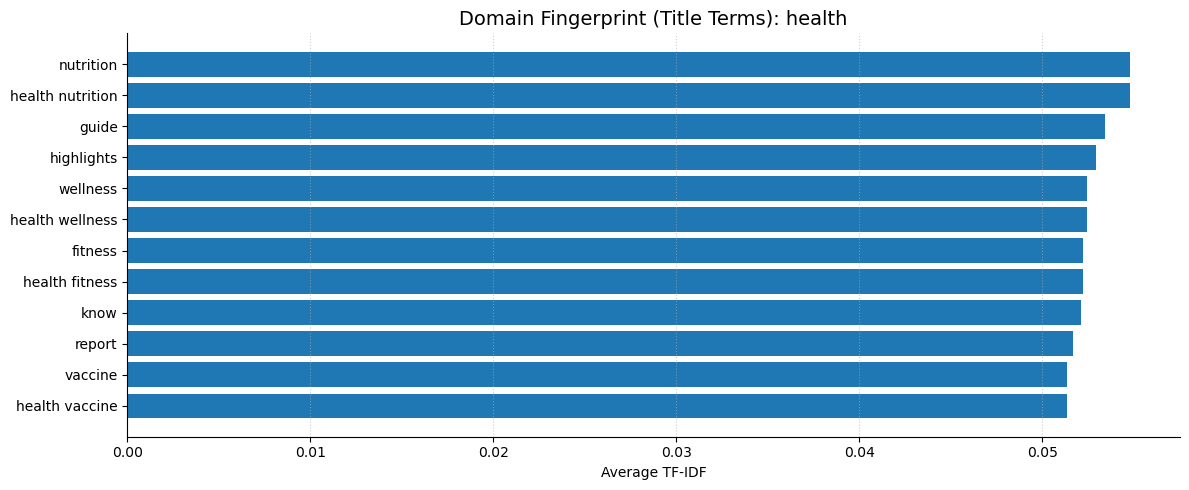

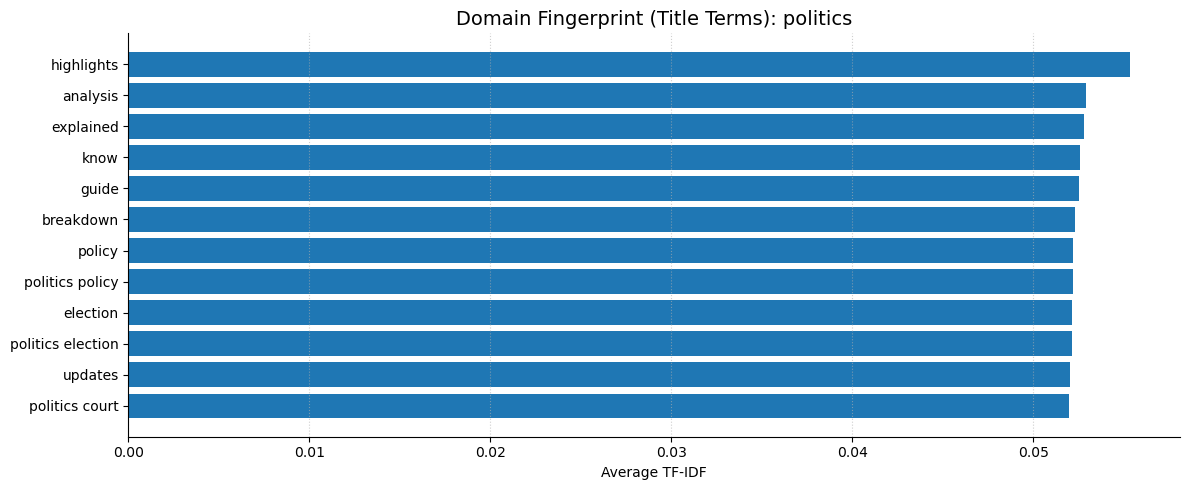

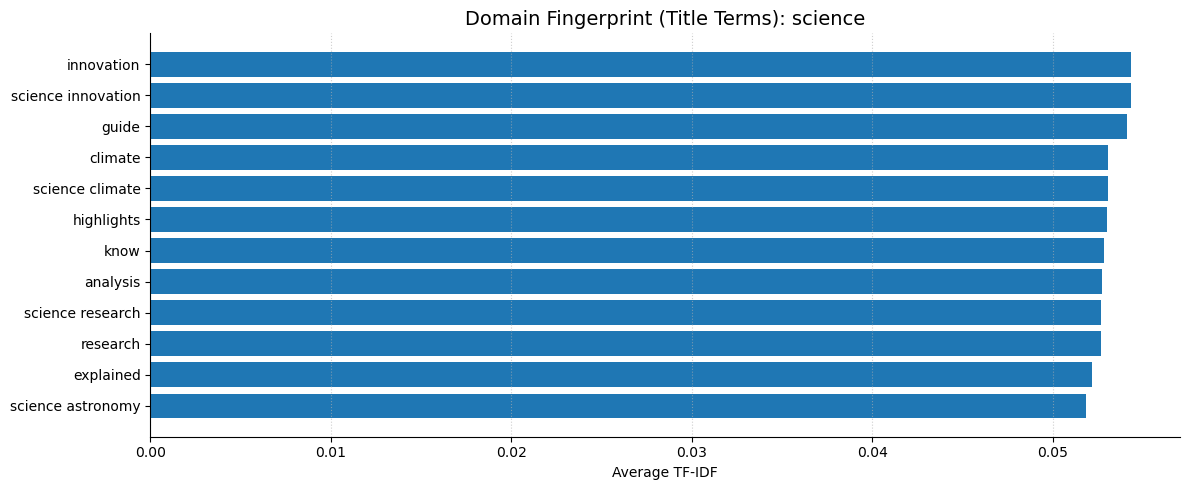

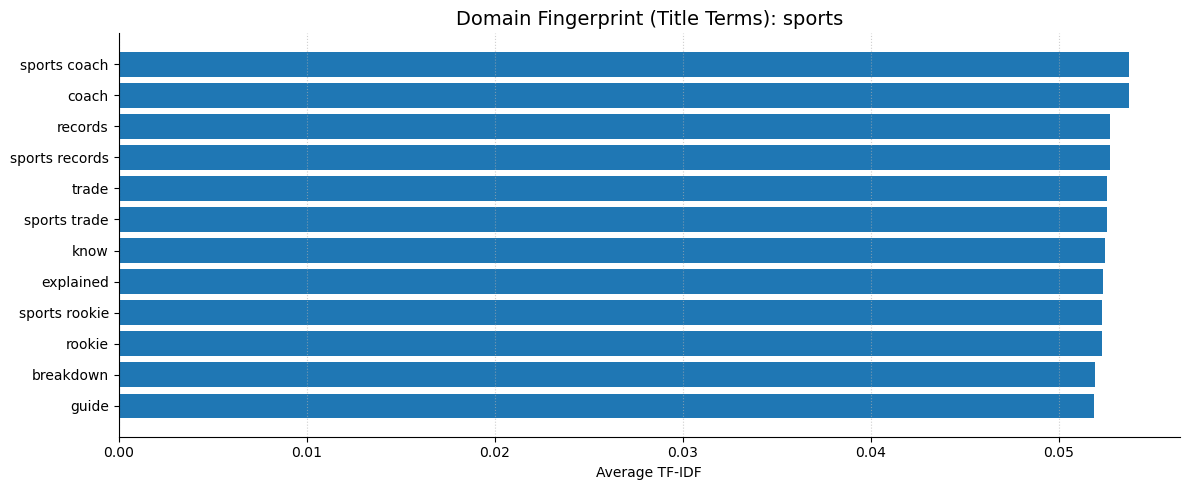

In [14]:
domains = df["article_domain"].dropna().unique()

for d in sorted(domains):
    subset = df.loc[df["article_domain"] == d, "title_clean"]
    if subset.shape[0] < 1000:
        continue
    
    terms_d, scores_d = top_terms(subset, ngram_range=(1,2), top_k=12)
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.barh(terms_d[::-1], scores_d[::-1])
    ax.set_title(f"Domain Fingerprint (Title Terms): {d}", fontsize=14)
    ax.set_xlabel("Average TF-IDF")
    ax.grid(True, axis="x", linestyle=":", alpha=0.6)
    ax.spines["top"].set_visible(False); ax.spines["right"].set_visible(False)
    plt.tight_layout()
    plt.show()


# How does vocabulary differ by domain, and which domain themes correlate with engagement?

Topic 0: sports providing, sports, developments sports, science providing, science, politics providing, politics, health providing, health, developments science
Topic 1: developments business, business providing, business, sports providing, sports, science providing, science, politics providing, politics, health providing
Topic 2: politics providing, politics, developments politics, sports providing, sports, science providing, science, health providing, health, developments sports
Topic 3: science providing, science, developments science, sports providing, sports, politics providing, politics, health providing, health, developments sports
Topic 4: health providing, health, developments health, sports providing, sports, science providing, science, politics providing, politics, developments sports
Topic 5: health providing, health, developments health, sports providing, sports, science providing, science, politics providing, politics, developments sports
Topic 6: sports providing, sports

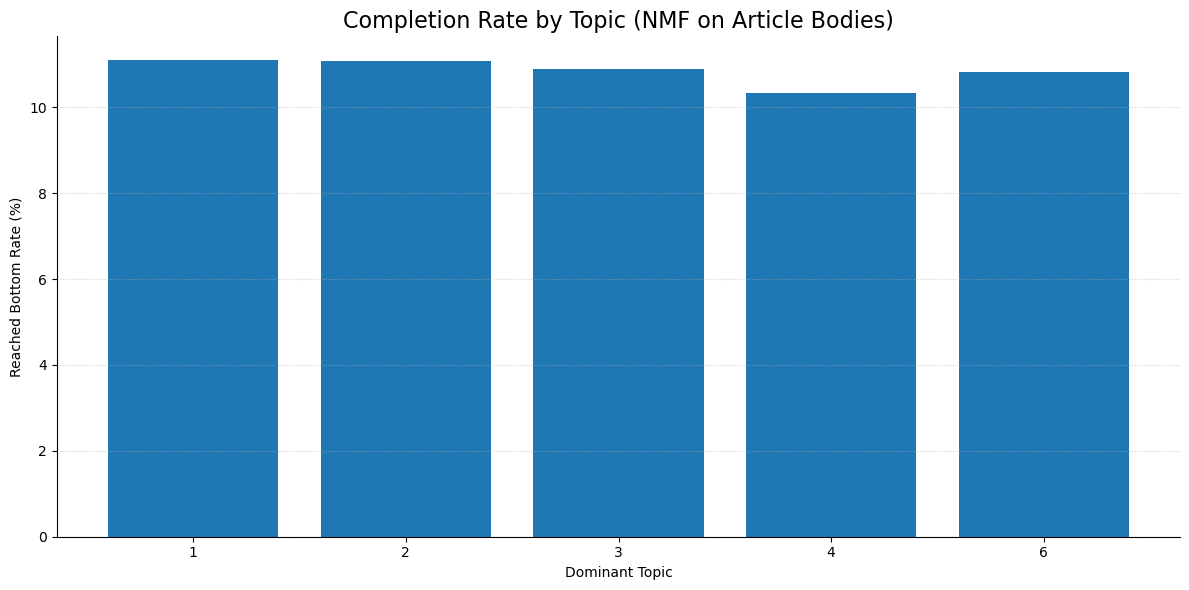

In [15]:
# Business question: “What are the core topics we publish, and which topics drive completion/time spent?”


from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer

# Use a sample for speed if needed
sample = df.sample(n=min(60000, len(df)), random_state=42).copy()

vec = TfidfVectorizer(stop_words="english", ngram_range=(1,2), min_df=20, max_df=0.6)
X = vec.fit_transform(sample["body_clean"])
terms = np.array(vec.get_feature_names_out())

n_topics = 8
nmf = NMF(n_components=n_topics, random_state=42, init="nndsvda", max_iter=300)
W = nmf.fit_transform(X)
H = nmf.components_

# Print top words per topic
top_words = 10
for k in range(n_topics):
    top_idx = np.argsort(H[k])[-top_words:][::-1]
    print(f"Topic {k}: " + ", ".join(terms[top_idx]))

# Assign dominant topic
sample["topic"] = W.argmax(axis=1)

topic_perf = (sample.groupby("topic")
              .agg(
                  sessions=("topic","size"),
                  completion_rate=("reached_bottom","mean"),
                  avg_time_spent=("time_spent_sec","mean")
              )
              .reset_index())
topic_perf["completion_rate"] *= 100

# Plot completion rate by topic
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(topic_perf["topic"].astype(str), topic_perf["completion_rate"])
ax.set_title("Completion Rate by Topic (NMF on Article Bodies)", fontsize=16)
ax.set_xlabel("Dominant Topic")
ax.set_ylabel("Reached Bottom Rate (%)")
ax.grid(True, axis="y", linestyle=":", alpha=0.6)
ax.spines["top"].set_visible(False); ax.spines["right"].set_visible(False)
plt.tight_layout(); plt.show()


# Do clickbaity/overpromising titles reduce completion?

/var/folders/v_/wt___8bn2w96qll7bdb9csb00000gn/T/ipykernel_49169/1248911603.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bucket = (sample.groupby("sim_bucket")


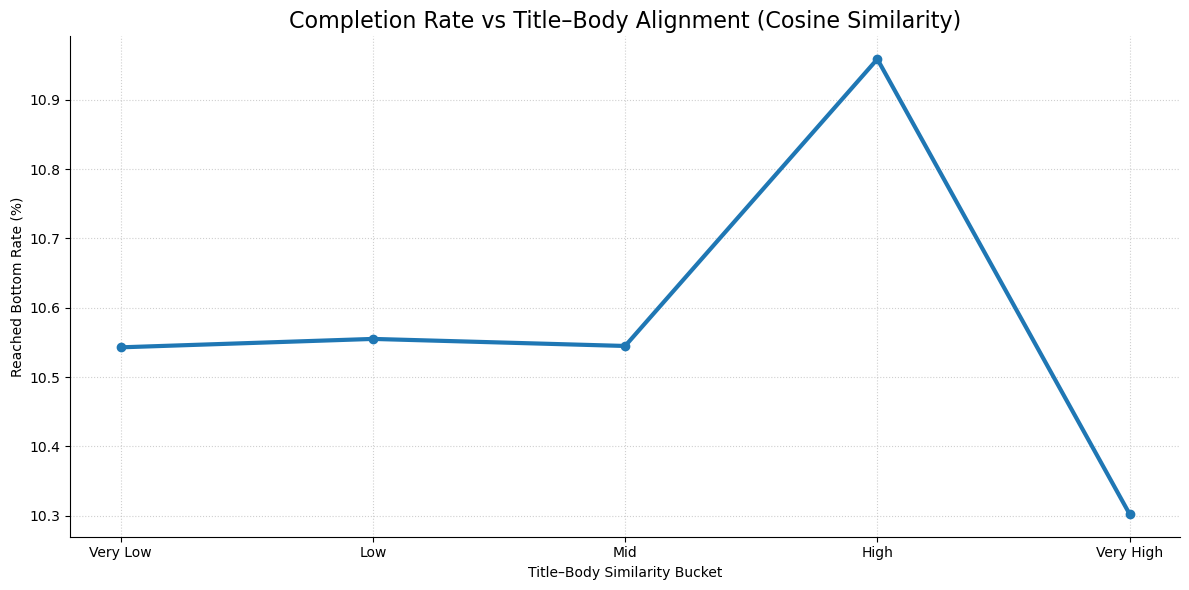

In [18]:



from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

sample = df.sample(n=min(50000, len(df)), random_state=7).copy()

vec = TfidfVectorizer(stop_words="english", ngram_range=(1,2), min_df=10, max_df=0.7)

X_title = vec.fit_transform(sample["title_clean"])
X_body  = vec.transform(sample["body_clean"])

# Cosine similarity per row
sim = np.array([cosine_similarity(X_title[i], X_body[i])[0,0] for i in range(X_title.shape[0])])
sample["title_body_similarity"] = sim

# Bucket similarity
sample["sim_bucket"] = pd.qcut(sample["title_body_similarity"], 5, labels=["Very Low","Low","Mid","High","Very High"])
bucket = (sample.groupby("sim_bucket")
          .agg(completion_rate=("reached_bottom","mean"),
               avg_time_spent=("time_spent_sec","mean"))
          .reset_index())
bucket["completion_rate"] *= 100

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(bucket["sim_bucket"].astype(str), bucket["completion_rate"], marker="o", linewidth=3)
ax.set_title("Completion Rate vs Title–Body Alignment (Cosine Similarity)", fontsize=16)
ax.set_xlabel("Title–Body Similarity Bucket")
ax.set_ylabel("Reached Bottom Rate (%)")
ax.grid(True, linestyle=":", alpha=0.6)
ax.spines["top"].set_visible(False); ax.spines["right"].set_visible(False)
plt.tight_layout(); plt.show()


# Defining Engagement score and analyzing distribution

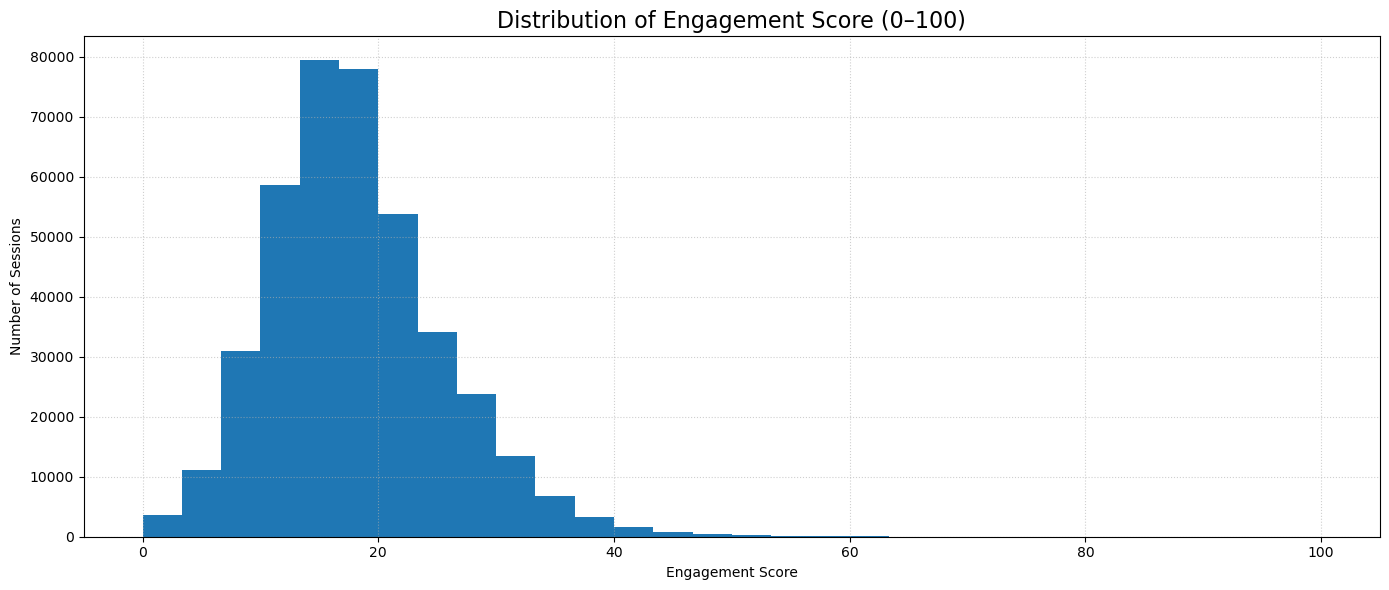

In [20]:
# Ensure numeric columns
cols = ["scroll_depth","time_spent_sec","reached_bottom",
        "clicked_suggested_link","watched_short_video"]

for col in cols:
    df[col] = pd.to_numeric(df[col], errors="coerce").fillna(0)

# Standardize scroll & time
scaler = StandardScaler()
scaled = scaler.fit_transform(df[["scroll_depth","time_spent_sec"]])
df["scroll_z"] = scaled[:, 0]
df["time_z"]   = scaled[:, 1]

# Engagement formula
df["engagement_score"] = (
    0.30 * df["scroll_z"] +
    0.30 * df["time_z"] +
    0.20 * df["reached_bottom"] +
    0.10 * df["clicked_suggested_link"] +
    0.10 * df["watched_short_video"]
)

# Normalize to 0–100 scale
df["engagement_score"] = 100 * (
    (df["engagement_score"] - df["engagement_score"].min()) /
    (df["engagement_score"].max() - df["engagement_score"].min())
)

# Histogram
plt.figure(figsize=(14,6))
plt.hist(df["engagement_score"], bins=30)

plt.title("Distribution of Engagement Score (0–100)", fontsize=16)
plt.xlabel("Engagement Score")
plt.ylabel("Number of Sessions")
plt.grid(True, linestyle=":", alpha=0.6)

plt.tight_layout()
plt.show()

# Logistic Regression

In [25]:
from sklearn.pipeline import Pipeline

# -----------------------------
# Create Engagement Score
# -----------------------------
eng_cols = ["scroll_depth","time_spent_sec","reached_bottom",
            "clicked_suggested_link","watched_short_video"]

for col in eng_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

df[eng_cols] = df[eng_cols].fillna(0)

from sklearn.preprocessing import StandardScaler
scaler_tmp = StandardScaler()
scaled = scaler_tmp.fit_transform(df[["scroll_depth","time_spent_sec"]])
df["scroll_z"] = scaled[:,0]
df["time_z"]   = scaled[:,1]

df["engagement_score"] = (
    0.30 * df["scroll_z"] +
    0.30 * df["time_z"] +
    0.20 * df["reached_bottom"] +
    0.10 * df["clicked_suggested_link"] +
    0.10 * df["watched_short_video"]
)

df["engagement_score"] = 100 * (
    (df["engagement_score"] - df["engagement_score"].min()) /
    (df["engagement_score"].max() - df["engagement_score"].min())
)

# Target: Top 30%
threshold = df["engagement_score"].quantile(0.70)
df["high_engagement"] = (df["engagement_score"] >= threshold).astype(int)

# -----------------------------
# Feature Selection
# -----------------------------
features = [
    "pageviews",
    "article_domain",
    "time_of_day",
    "platform",
    "device_os",
    "is_subscriber",
    "is_first_time_visit",
    "prior_articles_engaged",
    "prior_bounces",
    "battery_percent",
    "windows_open",
    "scroll_speed_px_per_sec",
    "breaking_news",
    "year",
    "month"
]

features = [f for f in features if f in df.columns]

X = df[features]
y = df["high_engagement"]

# Sample for speed
df_sample = df.sample(n=80000, random_state=42)
X = df_sample[features]
y = df_sample["high_engagement"]

# Identify numeric vs categorical
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = [c for c in X.columns if c not in numeric_features]

# -----------------------------
# Preprocessing Pipeline
# -----------------------------
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

# Logistic Regression Pipeline
model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("classifier", LogisticRegression(max_iter=1000))
])

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train
model.fit(X_train, y_train)

# Predict
proba = model.predict_proba(X_test)[:,1]
pred = (proba >= 0.5).astype(int)

print("AUC:", round(roc_auc_score(y_test, proba),4))
print("\nClassification Report:\n", classification_report(y_test, pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, pred))

AUC: 0.5029

Classification Report:
               precision    recall  f1-score   support

           0       0.70      1.00      0.83     11247
           1       0.00      0.00      0.00      4753

    accuracy                           0.70     16000
   macro avg       0.35      0.50      0.41     16000
weighted avg       0.49      0.70      0.58     16000

Confusion Matrix:
 [[11247     0]
 [ 4753     0]]


/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Feature Importance for Logistic Regression

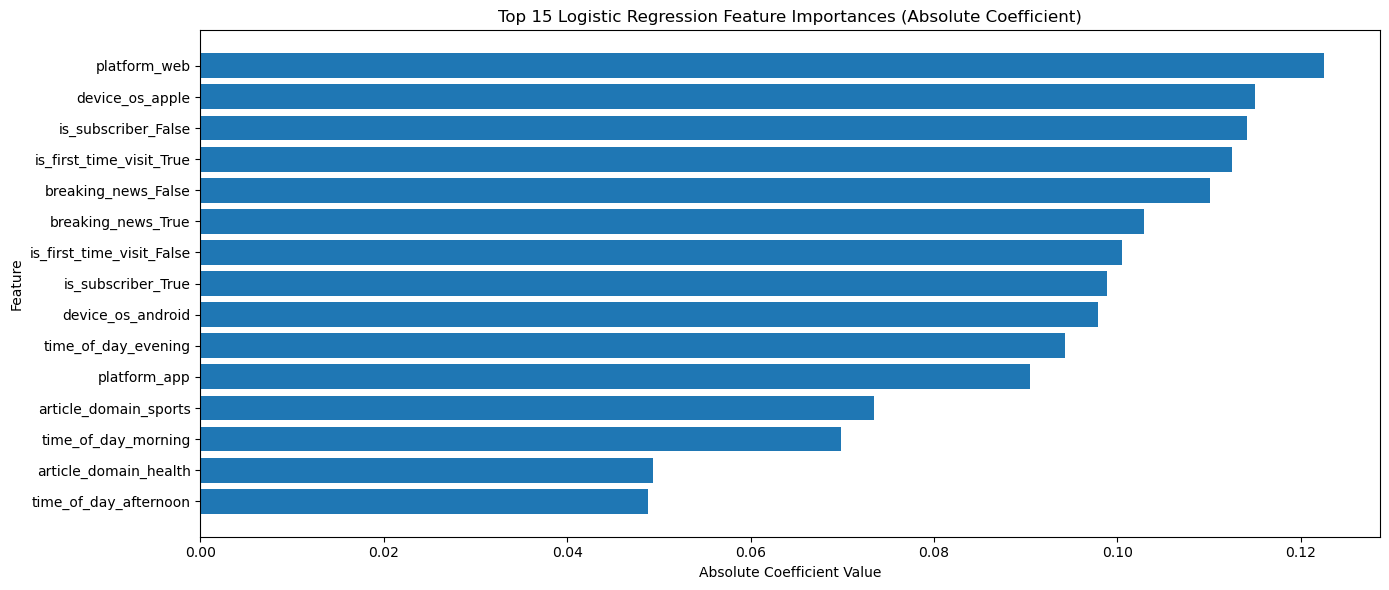

feature  coefficient  abs_coeff
15               platform_web    -0.122507   0.122507
17            device_os_apple    -0.115053   0.115053
18        is_subscriber_False    -0.114129   0.114129
21   is_first_time_visit_True    -0.112511   0.112511
22        breaking_news_False    -0.110065   0.110065
23         breaking_news_True    -0.102899   0.102899
20  is_first_time_visit_False    -0.100453   0.100453
19         is_subscriber_True    -0.098834   0.098834
16          device_os_android    -0.097911   0.097911
12        time_of_day_evening    -0.094254   0.094254
14               platform_app    -0.090457   0.090457
10      article_domain_sports    -0.073442   0.073442
13        time_of_day_morning    -0.069893   0.069893
7       article_domain_health    -0.049341   0.049341
11      time_of_day_afternoon    -0.048816   0.048816

In [26]:
# Feature Importance for Logistic Regression (High Engagement Model)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression



# -----------------------------
# Create Engagement Target (Top 30%)
# -----------------------------
eng_cols = ["scroll_depth","time_spent_sec","reached_bottom",
            "clicked_suggested_link","watched_short_video"]

for col in eng_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce").fillna(0)

from sklearn.preprocessing import StandardScaler
tmp_scaler = StandardScaler()
scaled = tmp_scaler.fit_transform(df[["scroll_depth","time_spent_sec"]])
df["scroll_z"] = scaled[:,0]
df["time_z"]   = scaled[:,1]

df["engagement_score"] = (
    0.30 * df["scroll_z"] +
    0.30 * df["time_z"] +
    0.20 * df["reached_bottom"] +
    0.10 * df["clicked_suggested_link"] +
    0.10 * df["watched_short_video"]
)

df["engagement_score"] = 100 * (
    (df["engagement_score"] - df["engagement_score"].min()) /
    (df["engagement_score"].max() - df["engagement_score"].min())
)

threshold = df["engagement_score"].quantile(0.70)
df["high_engagement"] = (df["engagement_score"] >= threshold).astype(int)

# -----------------------------
# Features
# -----------------------------
features = [
    "pageviews",
    "article_domain",
    "time_of_day",
    "platform",
    "device_os",
    "is_subscriber",
    "is_first_time_visit",
    "prior_articles_engaged",
    "prior_bounces",
    "battery_percent",
    "windows_open",
    "scroll_speed_px_per_sec",
    "breaking_news",
    "year",
    "month"
]

features = [f for f in features if f in df.columns]

# Sample for speed
df_sample = df.sample(n=60000, random_state=42)

X = df_sample[features]
y = df_sample["high_engagement"]

# Identify numeric vs categorical
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = [c for c in X.columns if c not in numeric_features]

# Preprocessing
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

# Logistic Regression Pipeline
model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("classifier", LogisticRegression(max_iter=1000))
])

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

model.fit(X_train, y_train)

# -----------------------------
# Extract Feature Names
# -----------------------------
onehot = model.named_steps["preprocess"].named_transformers_["cat"].named_steps["onehot"]
cat_feature_names = onehot.get_feature_names_out(categorical_features)

all_feature_names = np.concatenate([numeric_features, cat_feature_names])

coefficients = model.named_steps["classifier"].coef_[0]

feature_importance = pd.DataFrame({
    "feature": all_feature_names,
    "coefficient": coefficients,
    "abs_coeff": np.abs(coefficients)
}).sort_values("abs_coeff", ascending=False)

# Top 15 Most Important Features
top_features = feature_importance.head(15)

# Plot (single chart)
plt.figure(figsize=(14,6))
plt.barh(top_features["feature"][::-1], top_features["abs_coeff"][::-1])

plt.title("Top 15 Logistic Regression Feature Importances (Absolute Coefficient)")
plt.xlabel("Absolute Coefficient Value")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

top_features


# Gradient Boosting Classifier

In [32]:



# -----------------------------
# Create High Engagement Target
# -----------------------------
eng_cols = ["scroll_depth","time_spent_sec","reached_bottom",
            "clicked_suggested_link","watched_short_video"]

for col in eng_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce").fillna(0)

from sklearn.preprocessing import StandardScaler
tmp_scaler = StandardScaler()
scaled = tmp_scaler.fit_transform(df[["scroll_depth","time_spent_sec"]])
df["scroll_z"] = scaled[:,0]
df["time_z"]   = scaled[:,1]

df["engagement_score"] = (
    0.30 * df["scroll_z"] +
    0.30 * df["time_z"] +
    0.20 * df["reached_bottom"] +
    0.10 * df["clicked_suggested_link"] +
    0.10 * df["watched_short_video"]
)

df["engagement_score"] = 100 * (
    (df["engagement_score"] - df["engagement_score"].min()) /
    (df["engagement_score"].max() - df["engagement_score"].min())
)

threshold = df["engagement_score"].quantile(0.70)
df["high_engagement"] = (df["engagement_score"] >= threshold).astype(int)

# -----------------------------
# Feature Set (Lean + Numeric)
# -----------------------------
features = [
    "pageviews",
    "prior_articles_engaged",
    "prior_bounces",
    "battery_percent",
    "windows_open",
    "scroll_speed_px_per_sec",
    "is_subscriber",
    "is_first_time_visit",
    "breaking_news",
    "year",
    "month"
]

features = [f for f in features if f in df.columns]

df_sample = df.sample(n=40000, random_state=42)

X = df_sample[features]
y = df_sample["high_engagement"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# -----------------------------
# Train Gradient Boosting Model
# -----------------------------
model = HistGradientBoostingClassifier(
    learning_rate=0.08,
    max_depth=5,
    max_iter=250,
    random_state=42
)

model.fit(X_train, y_train)

proba = model.predict_proba(X_test)[:,1]
pred = (proba >= 0.5).astype(int)

print("Gradient Boosting AUC:", round(roc_auc_score(y_test, proba),4))
print("\nClassification Report:\n", classification_report(y_test, pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, pred))


Gradient Boosting AUC: 0.4987

Classification Report:
               precision    recall  f1-score   support

           0       0.70      1.00      0.83      5637
           1       0.00      0.00      0.00      2363

    accuracy                           0.70      8000
   macro avg       0.35      0.50      0.41      8000
weighted avg       0.50      0.70      0.58      8000

Confusion Matrix:
 [[5637    0]
 [2363    0]]


/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Decision Tree Classifier

In [34]:
# -----------------------------
# Create High Engagement Target (Top 30%)
# -----------------------------
eng_cols = ["scroll_depth","time_spent_sec","reached_bottom",
            "clicked_suggested_link","watched_short_video"]

for col in eng_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce").fillna(0)

scaler_tmp = StandardScaler()
scaled = scaler_tmp.fit_transform(df[["scroll_depth","time_spent_sec"]])
df["scroll_z"] = scaled[:,0]
df["time_z"]   = scaled[:,1]

df["engagement_score"] = (
    0.30 * df["scroll_z"] +
    0.30 * df["time_z"] +
    0.20 * df["reached_bottom"] +
    0.10 * df["clicked_suggested_link"] +
    0.10 * df["watched_short_video"]
)

df["engagement_score"] = 100 * (
    (df["engagement_score"] - df["engagement_score"].min()) /
    (df["engagement_score"].max() - df["engagement_score"].min())
)

threshold = df["engagement_score"].quantile(0.70)
df["high_engagement"] = (df["engagement_score"] >= threshold).astype(int)

# -----------------------------
# Feature Selection (Numeric for Simplicity)
# -----------------------------
features = [
    "pageviews",
    "prior_articles_engaged",
    "prior_bounces",
    "battery_percent",
    "windows_open",
    "scroll_speed_px_per_sec",
    "is_subscriber",
    "is_first_time_visit",
    "breaking_news",
    "year",
    "month"
]

features = [f for f in features if f in df.columns]

df_sample = df.sample(n=40000, random_state=42)

X = df_sample[features].fillna(0)
y = df_sample["high_engagement"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# -----------------------------
# Train Decision Tree
# -----------------------------
model = DecisionTreeClassifier(
    max_depth=6,
    min_samples_leaf=100,
    random_state=42
)

model.fit(X_train, y_train)

proba = model.predict_proba(X_test)[:,1]
pred = (proba >= 0.5).astype(int)

print("Decision Tree AUC:", round(roc_auc_score(y_test, proba),4))
print("\nClassification Report:\n", classification_report(y_test, pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, pred))

Decision Tree AUC: 0.5108

Classification Report:
               precision    recall  f1-score   support

           0       0.70      1.00      0.83      5637
           1       0.00      0.00      0.00      2363

    accuracy                           0.70      8000
   macro avg       0.35      0.50      0.41      8000
weighted avg       0.50      0.70      0.58      8000

Confusion Matrix:
 [[5637    0]
 [2363    0]]


/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Decision Tree Feature Importance

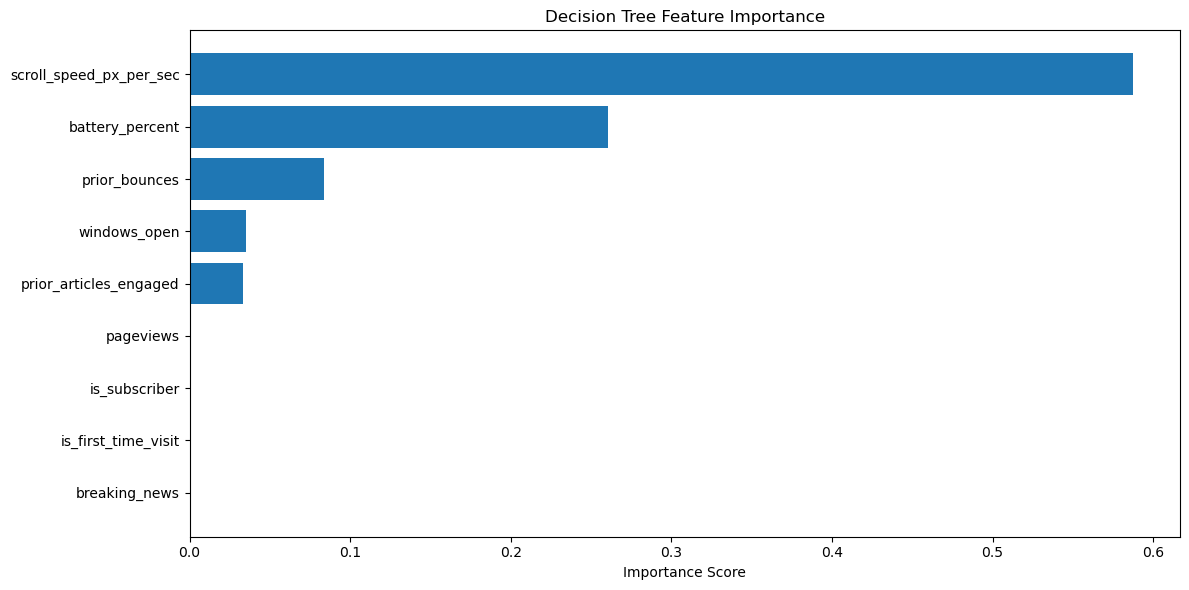

feature  importance
5  scroll_speed_px_per_sec    0.587368
3          battery_percent    0.260399
2            prior_bounces    0.083767
4             windows_open    0.034954
1   prior_articles_engaged    0.033513
0                pageviews    0.000000
6            is_subscriber    0.000000
7      is_first_time_visit    0.000000
8            breaking_news    0.000000

In [35]:
importance = pd.DataFrame({
    "feature": features,
    "importance": model.feature_importances_
}).sort_values("importance", ascending=False)

plt.figure(figsize=(12,6))
plt.barh(importance["feature"][::-1],
         importance["importance"][::-1])

plt.title("Decision Tree Feature Importance")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

importance


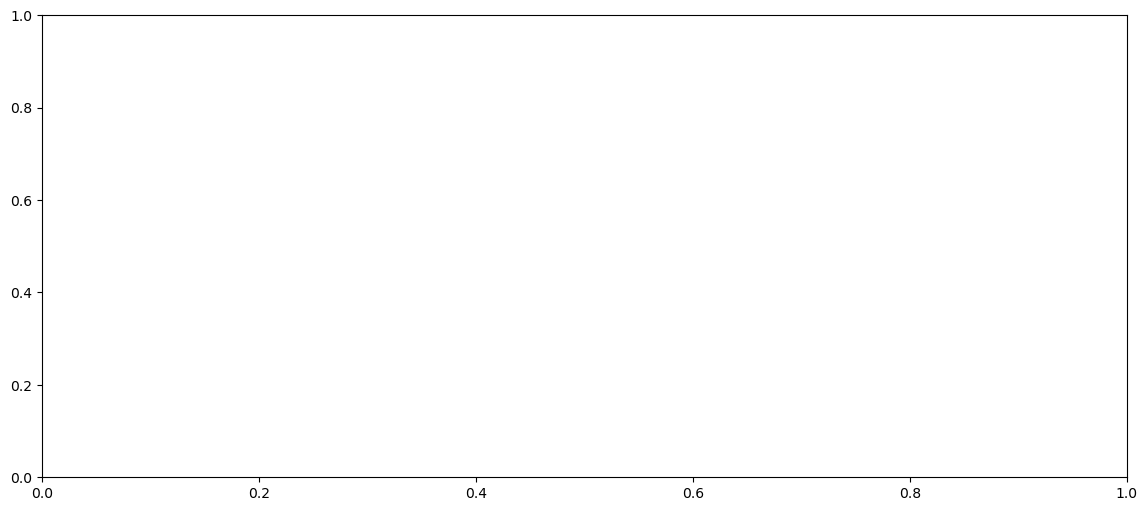

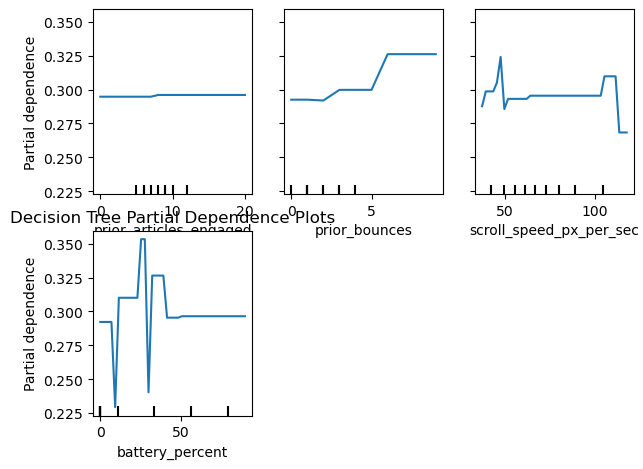

In [36]:
pdp_features = ["prior_articles_engaged",
                "prior_bounces",
                "scroll_speed_px_per_sec",
                "battery_percent"]

pdp_features = [f for f in pdp_features if f in X_test.columns]

fig, ax = plt.subplots(figsize=(14,6))
PartialDependenceDisplay.from_estimator(
    model, X_test,
    features=pdp_features[:4],
    grid_resolution=40
)

plt.title("Decision Tree Partial Dependence Plots")
plt.tight_layout()
plt.show()


# Random Forrest Classifier

In [39]:



# -----------------------------
# Create High Engagement Target (Top 30%)
# -----------------------------
eng_cols = ["scroll_depth","time_spent_sec","reached_bottom",
            "clicked_suggested_link","watched_short_video"]

for col in eng_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce").fillna(0)

scaler_tmp = StandardScaler()
scaled = scaler_tmp.fit_transform(df[["scroll_depth","time_spent_sec"]])
df["scroll_z"] = scaled[:,0]
df["time_z"]   = scaled[:,1]

df["engagement_score"] = (
    0.30 * df["scroll_z"] +
    0.30 * df["time_z"] +
    0.20 * df["reached_bottom"] +
    0.10 * df["clicked_suggested_link"] +
    0.10 * df["watched_short_video"]
)

df["engagement_score"] = 100 * (
    (df["engagement_score"] - df["engagement_score"].min()) /
    (df["engagement_score"].max() - df["engagement_score"].min())
)

threshold = df["engagement_score"].quantile(0.70)
df["high_engagement"] = (df["engagement_score"] >= threshold).astype(int)

# -----------------------------
# Feature Set (Numeric Only)
# -----------------------------
features = [
    "pageviews",
    "prior_articles_engaged",
    "prior_bounces",
    "battery_percent",
    "windows_open",
    "scroll_speed_px_per_sec",
    "is_subscriber",
    "is_first_time_visit",
    "breaking_news",
    "year",
    "month"
]

features = [f for f in features if f in df.columns]

# Sample for speed
df_sample = df.sample(n=60000, random_state=42)

X = df_sample[features].fillna(0)
y = df_sample["high_engagement"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# -----------------------------
# Train Random Forest
# -----------------------------
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_leaf=50,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

proba = rf.predict_proba(X_test)[:,1]
pred = (proba >= 0.5).astype(int)

print("Random Forest AUC:", round(roc_auc_score(y_test, proba),4))
print("\nClassification Report:\n", classification_report(y_test, pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, pred))


Random Forest AUC: 0.5025

Classification Report:
               precision    recall  f1-score   support

           0       0.70      1.00      0.83      8449
           1       0.00      0.00      0.00      3551

    accuracy                           0.70     12000
   macro avg       0.35      0.50      0.41     12000
weighted avg       0.50      0.70      0.58     12000

Confusion Matrix:
 [[8449    0]
 [3551    0]]


/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Random Forest Feature Importance

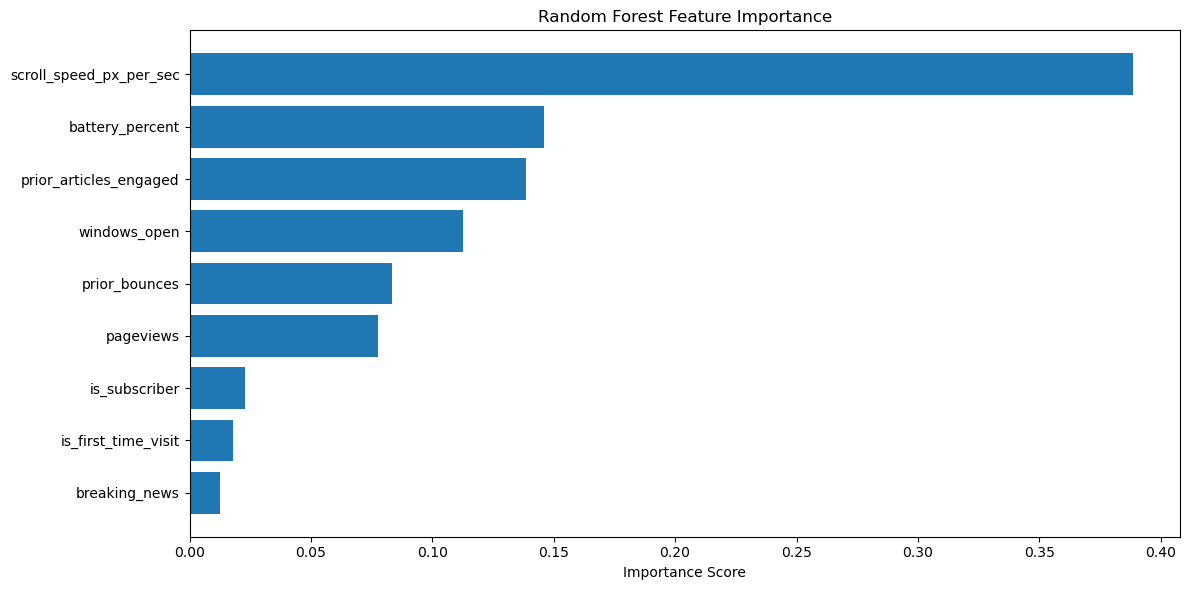

feature  importance
5  scroll_speed_px_per_sec    0.388547
3          battery_percent    0.146188
1   prior_articles_engaged    0.138611
4             windows_open    0.112586
2            prior_bounces    0.083420
0                pageviews    0.077525
6            is_subscriber    0.022679
7      is_first_time_visit    0.017739
8            breaking_news    0.012706

In [40]:
importance = pd.DataFrame({
    "feature": features,
    "importance": rf.feature_importances_
}).sort_values("importance", ascending=False)

plt.figure(figsize=(12,6))
plt.barh(importance["feature"][::-1],
         importance["importance"][::-1])

plt.title("Random Forest Feature Importance")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

importance


# Which users should we target to increase engagement — not just who is likely to engage?

In [42]:
# Ensure numeric
df["watched_short_video"] = pd.to_numeric(df["watched_short_video"], errors="coerce").fillna(0)
df["reached_bottom"] = pd.to_numeric(df["reached_bottom"], errors="coerce").fillna(0)

# Treatment = watched video
T = df["watched_short_video"]

# Outcome = reached bottom (engagement event)
Y = df["reached_bottom"]

# Feature set (exclude treatment + outcome)
features = [
    "pageviews",
    "prior_articles_engaged",
    "prior_bounces",
    "battery_percent",
    "windows_open",
    "scroll_speed_px_per_sec",
    "is_subscriber",
    "is_first_time_visit",
    "breaking_news",
    "year",
    "month"
]

features = [f for f in features if f in df.columns]

df_sample = df.sample(n=50000, random_state=42)

X = df_sample[features].fillna(0)
T = df_sample["watched_short_video"]
Y = df_sample["reached_bottom"]

In [43]:
# Split
X_train, X_test, T_train, T_test, Y_train, Y_test = train_test_split(
    X, T, Y, test_size=0.2, random_state=42
)

# Train treated model
model_treated = RandomForestClassifier(
    n_estimators=200,
    min_samples_leaf=50,
    random_state=42,
    n_jobs=-1
)

model_treated.fit(X_train[T_train == 1], Y_train[T_train == 1])

# Train control model
model_control = RandomForestClassifier(
    n_estimators=200,
    min_samples_leaf=50,
    random_state=42,
    n_jobs=-1
)

model_control.fit(X_train[T_train == 0], Y_train[T_train == 0])

# Predict uplift on test set
p_treated = model_treated.predict_proba(X_test)[:,1]
p_control = model_control.predict_proba(X_test)[:,1]

uplift = p_treated - p_control


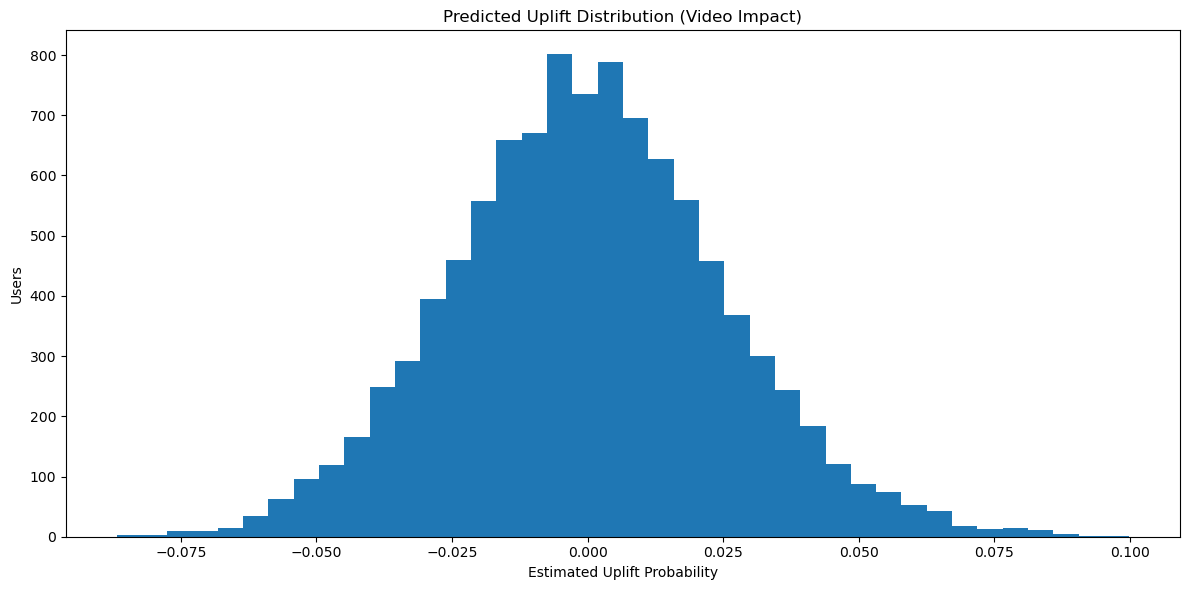

np.float64(0.00010264447805204949)

In [44]:
plt.figure(figsize=(12,6))
plt.hist(uplift, bins=40)
plt.title("Predicted Uplift Distribution (Video Impact)")
plt.xlabel("Estimated Uplift Probability")
plt.ylabel("Users")
plt.tight_layout()
plt.show()

uplift.mean()


In [45]:
uplift_df = X_test.copy()
uplift_df["uplift_score"] = uplift

# Top 10% highest uplift users
threshold = np.percentile(uplift, 90)
target_users = uplift_df[uplift_df["uplift_score"] >= threshold]

print("Users to Target (Top 10% Uplift):", len(target_users))
target_users.head()


Users to Target (Top 10% Uplift): 1000


pageviews  prior_articles_engaged  prior_bounces  battery_percent  \
29538           3                       8              1             43.0   
182009          3                       9              4             46.0   
230767          2                       7              3              5.0   
335856          4                       3              3              0.0   
339655          2                       7              1              0.0   

        windows_open  scroll_speed_px_per_sec  is_subscriber  \
29538              5                     67.7          False   
182009             5                     64.1          False   
230767             6                     85.2          False   
335856             2                     64.9          False   
339655             5                     60.1          False   

        is_first_time_visit  breaking_news  uplift_score  
29538                 False          False      0.032795  
182009                False          False      0.067434  
230767                False          False      0.065083  
335856                False          False      0.034359  
339655                False          False      0.038712

# Uplift Modeling

In [46]:
df["watched_short_video"] = pd.to_numeric(df["watched_short_video"], errors="coerce").fillna(0)
df["reached_bottom"] = pd.to_numeric(df["reached_bottom"], errors="coerce").fillna(0)

features = [
    "pageviews",
    "prior_articles_engaged",
    "prior_bounces",
    "battery_percent",
    "windows_open",
    "scroll_speed_px_per_sec",
    "is_subscriber",
    "is_first_time_visit",
    "breaking_news",
    "year",
    "month"
]

features = [f for f in features if f in df.columns]

df_sample = df.sample(n=50000, random_state=42)

X = df_sample[features].fillna(0)
T = df_sample["watched_short_video"]
Y = df_sample["reached_bottom"]

X_train, X_test, T_train, T_test, Y_train, Y_test = train_test_split(
    X, T, Y, test_size=0.2, random_state=42
)

model_treated = RandomForestClassifier(n_estimators=150, min_samples_leaf=50, random_state=42, n_jobs=-1)
model_control = RandomForestClassifier(n_estimators=150, min_samples_leaf=50, random_state=42, n_jobs=-1)

model_treated.fit(X_train[T_train==1], Y_train[T_train==1])
model_control.fit(X_train[T_train==0], Y_train[T_train==0])

p_treated = model_treated.predict_proba(X_test)[:,1]
p_control = model_control.predict_proba(X_test)[:,1]

uplift = p_treated - p_control

uplift_df = X_test.copy()
uplift_df["uplift_score"] = uplift

In [47]:
threshold = np.percentile(uplift, 90)

uplift_df["top_uplift"] = (uplift_df["uplift_score"] >= threshold).astype(int)

top_group = uplift_df[uplift_df["top_uplift"] == 1]
rest_group = uplift_df[uplift_df["top_uplift"] == 0]

print("Top uplift users:", len(top_group))


Top uplift users: 1000


In [48]:
comparison = pd.DataFrame({
    "Top_Uplift_Avg": top_group.mean(),
    "Rest_Avg": rest_group.mean()
})

comparison["Difference"] = comparison["Top_Uplift_Avg"] - comparison["Rest_Avg"]

comparison.sort_values("Difference", ascending=False)


Top_Uplift_Avg   Rest_Avg  Difference
scroll_speed_px_per_sec       72.707800  71.180956    1.526844
top_uplift                     1.000000   0.000000    1.000000
prior_bounces                  2.192000   1.965333    0.226667
uplift_score                   0.045603  -0.004974    0.050577
breaking_news                  0.147000   0.115000    0.032000
pageviews                      2.369000   2.397444   -0.028444
windows_open                   4.935000   4.988444   -0.053444
is_subscriber                  0.136000   0.251333   -0.115333
is_first_time_visit            0.064000   0.184333   -0.120333
prior_articles_engaged         6.714000   8.186222   -1.472222
battery_percent               10.015000  23.891000  -13.876000

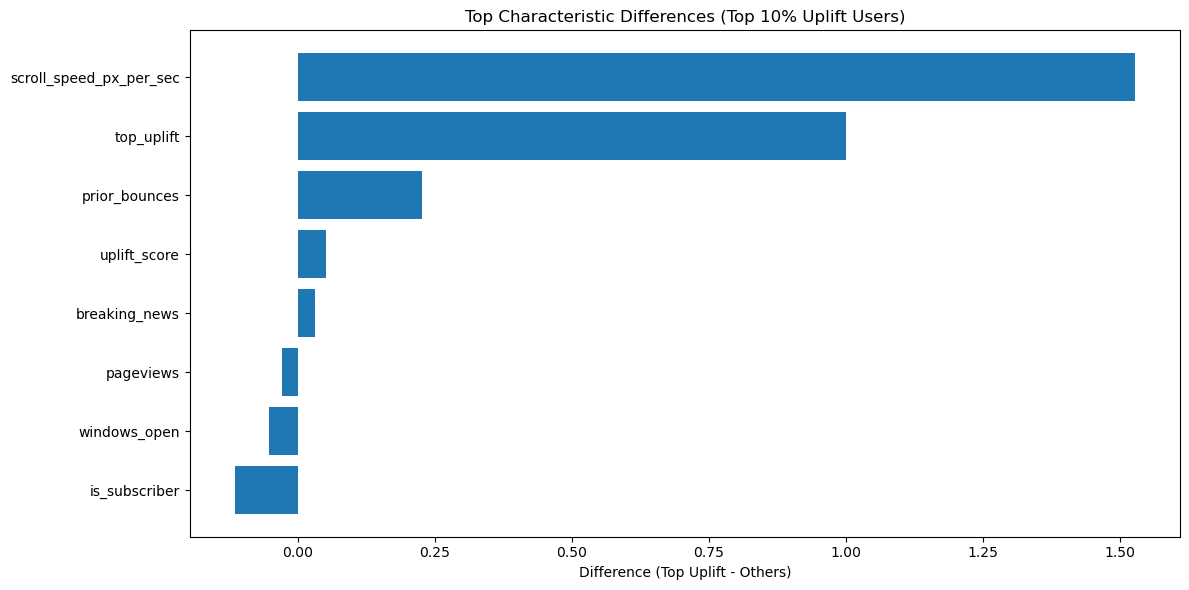

Top_Uplift_Avg   Rest_Avg  Difference
scroll_speed_px_per_sec       72.707800  71.180956    1.526844
top_uplift                     1.000000   0.000000    1.000000
prior_bounces                  2.192000   1.965333    0.226667
uplift_score                   0.045603  -0.004974    0.050577
breaking_news                  0.147000   0.115000    0.032000
pageviews                      2.369000   2.397444   -0.028444
windows_open                   4.935000   4.988444   -0.053444
is_subscriber                  0.136000   0.251333   -0.115333

In [49]:
top_diffs = comparison.sort_values("Difference", ascending=False).head(8)

plt.figure(figsize=(12,6))
plt.barh(top_diffs.index[::-1],
         top_diffs["Difference"][::-1])

plt.title("Top Characteristic Differences (Top 10% Uplift Users)")
plt.xlabel("Difference (Top Uplift - Others)")
plt.tight_layout()
plt.show()

top_diffs
